# NOTINO Sampling Campaigns Optimisation - Probability-based classification models

The following sections document the development process of a probability-based binary classification model built upon Notino sampling campaign transactions recorded between June 2018 and June 2020, which would allow Notino to better target customers during their sampling campaigns, with the aim of increasing performance of these campaigns in terms of conversion rate. 

In [97]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pymssql
import tables
from notino.utils_binary_classification import *
from notino.utils_recommender import dump_df_to_hdf5
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from initialize import (camp_smr, sep_camp_smr, fmt, highlight_col, cm, cm2, engine)
from sklearn.linear_model import LogisticRegression
from datetime import datetime, timedelta
from IPython.display import HTML, display, IFrame, Markdown as md
from IPython import get_ipython

%reload_ext autoreload
get_ipython().magic("autoreload 2");
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.xmargin'] = 0.01
plt.rcParams['axes.titlesize'] = 10
pd.set_option('display.float_format', lambda x: '%.0f' % x if (x == x and x*10 % 10 == 0) else ('%.1f' % x if (x == x and x*100 % 10 == 0) else '%.2f' % x))
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 70)
pd.set_option('max_colwidth', 400)

%matplotlib inline

## 1. Extraction from DB and preparation of campaign transactions  ---> **RUN ONLY ONCE**

### 1.1 Download items and transactions from the database into HDF5 files

First, a total of **520 separable sampling campaigns were processed, by extracting transaction items representing products and samples from the campaign transactions** with distributed samples and storing into HDF5 files. Identification of the campaign transactions was based on comparing campaign columns `start_date` and `end_date` versus transaction `order_date`. Each campaign transaction had to include the transaction item with `product_id` equal to campaign `sample_id`. All samples found in the campaign transactions were separately labeled by the `campaign_id` mapped from the MSExcel source (technically from the `campaign_summary` table stored in the database). That means, if a transaction contained multiple samples, each sample received its own `campaign_id` identifier. If any sample on a transaction could not be mapped to any campaign based on the `sample_id` and campaign `start_date` and `end_date`, these samples were excluded from the transaction, so that the counts of samples on transactions were not distorted. Since for some campaigns the product category of the distributed sample was different from `V (Samples)`, these campaigns were not included in the further analyses. Also excluded were transactions with zero products (only samples). Finally, transactions that had missing `customer_id` were also excluded, since they could not be used for mapping follow-up (conversion) transactions.

In [ ]:
txn_itm_smpl_to_hdf5(file_save='./data/hdf5/smpl/txn_itm_smpl_520.h5', camp_start=390, camp_end=520) # boundaries = [130, 260, 390, 520]

Next, stored **transaction items for campaign transactions were loaded, aggregated into transaction level** and stored into HDF5 files. Moreover, several potential predictors were calculated during the aggregation, such as `products`, `samples`, `campaign_length`, `amount_czk`, and `watched_products`. The list of watched products was generated by taking all `product_id` identifiers of full products from the campaign definitions, whose samples were present on given transaction.

In [21]:
txn_smpl_to_hdf5(file_read='./data/hdf5/smpl/txn_itm_smpl_260.h5', file_save='./hdf5/smpl/txn_smpl_260.h5') 

Lastly, **the campaign transactions were loaded** from storage HDF5 files into an input dataframe further processed below.

In [3]:
txn_smpl_input = txn_smpl_load_all(file_pattern='./data/hdf5/smpl/txn_smpl_', periods=[130, 260, 390, 520], key='camp')

The number of transactions loaded from HDF5 file is **1,944,692.**

### 1.2 Last-order-date adjustments

Since the conversion of the **campaign transactions was prescribed to be evaluated using 120-day conversion window**, the last possible `order_date` of a campaign transaction was set to 120 days before last available transaction in the database, which was recorded on `20.10.2020`. **Therefore as the `last_order_date` parameter of the transaction-filtering function, `22.6.2020` was used.**

In [4]:
txn_smpl_cut = txn_smpl_cut_last_order(df=txn_smpl_input, last_order_date='2020-06-22')

The number of unique transactions with distributed samples after cutting last
    order is **1,851,836**.

### 1.3 Disjoint conversion windows 

The analysis of transaction data revealed that there is a non-negligible amount of customers (approx. 62K customers with 237K transactions), who received in two separate transactions at least one identical sample (i.e. they were twice targeted by the same campaign). This implies that transactions of these customers can potentially interfere with each other's conversion evaluation (i.e. 120-day conversion windows for two transactions of one customer may overlap and blur the information about which campaign transaction contributed to the possible conversion). Therefore, **it was decided to exclude, separately for each customer, all such transactions whose `next_date` (i.e. next order date) was less than 120 days from the transaction `order_date`**.

In [5]:
txn_smpl = txn_smpl_get_disjoint_windows(df=txn_smpl_cut, window=120)

,transaction_id,customer_id,campaign_id,order_date,country_id,sample_campaign_id,product_class,category_product,category_sample,products,samples,campaign_length,amount_czk,watched_product_id,watched_products
0,35734064,00001381-af29-4533-9479-f3fbcd0a229d,201,2018-11-20,AT,[201],[Parfums],[Perfumes],[Perfumes],1,1,34,1724.23,"{LAMTNUW_AEDP05, LAMTNUW_AEDP10, LAMTNUW_AEDP30, LAMTNUW_AEDP20}",4
1,42342619,00001f87-6eca-4c8e-9849-5c85b87d32df,5,2019-08-05,SK,"[5, 47]",[Cosmetics],"[Body, Makeup, Skin]",[Skin],6,2,49,1060.91,"{ASMFEBW_KFCR09, BIRPNTW_KPCR10, BIRPNTW_KPCR15, BIRPNTW_KPCR05}",4
2,43744692,00001f87-6eca-4c8e-9849-5c85b87d32df,77,2019-10-02,SK,"[77, 315]",[Cosmetics],"[Makeup, Skin]",[Perfumes],8,2,32,1504.51,"{YSLLBRW_AEDP10, CHRGOGW_AEDP10, YSLLBRW_AEDP30, CHRGDDW_AEDP11, YSLLBRW_AEDP20, CHRGOGW_AEDP20, CHRGOGW_AEDP30}",7
4,43612354,00002511-13e5-4253-9ba2-6aa68df2fed4,256,2019-09-28,DE,"[256, 394]",[Parfums],[Perfumes],[Perfumes],2,2,41,1389.94,"{BURHERW_AEDP30, SAFSIMW_AEDP20, SAFSIMW_AEDP30, SAFSIMW_AEDP10, BURHERW_AEDP20, BURHERW_AEDP40, BURHERW_AEDP10}",7
5,47524762,00002558-343c-456e-b19c-2517877176e5,380,2020-01-13,SK,"[359, 380, 758, 844]",[Cosmetics],"[Hair, Makeup, Skin]","[Makeup, Skin]",4,4,33,1161.65,"{LAMGEAW_KFSR15, LAMGEAW_KFSR18, LAMTIUW_KMUP24, LAMGEAW_KFSR17, LAMGEAW_KFSR16, LRPEFCW_KECL80, LRPEFCW_KECL71, LRPEFCW_KDCR55}",8


The final number of unique transactions with distributed samples is **1,708,628.**


The number of customers is **1,324,847.**


The final number of unique transactions with distributed samples as a fraction of
    the transactions from previous step is **92.3%.**

### 1.4 Extraction of the binary response variable 

Let's calculate for each campaign transaction the **binary conversion variable**. The algorithm takes the `customer_id`, `watched_products` and `order_date` of the given campaign transaction and looks for follow-up transactions of the same customer, **placed during the conversion window of 120 days following `order_date` of the  campaign transaction.** In order not to check too many transactions in vain, for each evaluated campaign a single filter was applied in the first step, by selecting only customers who had at least two transactions in the watched period `[start_date, end_date + 120 days]` where start/end dates are derived from the transaction's `campaign_id`, which is basically the first (i.e. with lowest id) campaign by which that transaction was affected/targeted. Normally, campaign transaction has samples from multiple campaigns. The `campaign_id` assigned to each transaction serves actually as an convenience group identifier of the transaction within the whole dataset. If the algorithm found that the customer of the evaluated campaign transaction met the necessary condition of having two transactions in the watched period, his transactions from that period were used as an input to the second stage where conversion windows of his campaign transaction were searched for potential conversions.

In [ ]:
txn_smpl_conversions_to_hdf5(df=txn_smpl, file_save='./data/hdf5/smpl/txn_smpl_conv_130.h5', 0, 130)

In [ ]:
txn_smpl_conversions_to_hdf5(df=txn_smpl, file_save='./data/hdf5/smpl/txn_smpl_conv_260.h5', 130, 260)

In [ ]:
txn_smpl_conversions_to_hdf5(df=txn_smpl, file_save='./data/hdf5/smpl/txn_smpl_conv_390.h5', 260, 390)

In [ ]:
txn_smpl_conversions_to_hdf5(df=txn_smpl, file_save='./data/hdf5/smpl/txn_smpl_conv_520.h5', 390, 520)

### 1.5 Extraction of the RFM predictors (i.e. recency, frequency, monetary) 

In order to increase the predictive potential of the classifier models that will be built in further sections, we decided to include among the considered predictors also transction history-based variables related to customer's past purchasing behavior, such as number of previous transactions, number of days elapsed since last transaction and the total sales amount of his transactions.

In [ ]:
txn_smpl_rfm_to_hdf5(txn_smpl, './data/hdf5/smpl/txn_smpl_rfm_130.h5', 0, 130)

In [ ]:
txn_smpl_rfm_to_hdf5(txn_smpl, './data/hdf5/smpl/txn_smpl_rfm_260.h5', 130, 260)

In [ ]:
txn_smpl_rfm_to_hdf5(txn_smpl, './data/hdf5/smpl/txn_smpl_rfm_390.h5', 260, 390)

In [ ]:
txn_smpl_rfm_to_hdf5(txn_smpl, './data/hdf5/smpl/txn_smpl_rfm_520.h5', 390, 520)

### 1.6 Extraction of the customers gender 

Apart from RFM predictors, we also decided to use customer's gender as a potential predictor variable.

In [ ]:
txn_smpl_gender_to_hdf5(df=txn_smpl, file_save='./data/hdf5/smpl/txn_smpl_gender_520.h5')

## 2. Data initialisation

### 2.1 Loading development sample and several other columns from HDF5 files

First, load the development sample of campaign transactions.

In [10]:
periods = [130, 260, 390, 520]
txn_smpl_input = txn_smpl_load_all(file_pattern='./data/hdf5/smpl/txn_smpl_', periods=periods, key='camp')

The number of transactions loaded from HDF5 file is **1,944,692.**

### 2.2 Last-order-date adjustments

Adjust the campaign transactions dataset by excluding the most recent transactions.

In [11]:
txn_smpl_cut = txn_smpl_cut_last_order(df=txn_smpl_input, last_order_date='2020-06-22')

The number of unique transactions with distributed samples after cutting last
    order is **1,851,836**.

### 2.3 Disjoint conversion windows 

In [12]:
txn_smpl = txn_smpl_get_disjoint_windows(df=txn_smpl_cut, window=120)
md(f"The development sample date range is from **{txn_smpl.order_date.min():%d.%m.%Y}** to **{txn_smpl.order_date.max():%d.%m.%Y}**.")

,transaction_id,customer_id,campaign_id,order_date,country_id,sample_campaign_id,product_class,category_product,category_sample,products,samples,campaign_length,amount_czk,watched_product_id,watched_products
0,35734064,00001381-af29-4533-9479-f3fbcd0a229d,201,2018-11-20,AT,[201],[Parfums],[Perfumes],[Perfumes],1,1,34,1724.23,"{LAMTNUW_AEDP20, LAMTNUW_AEDP05, LAMTNUW_AEDP10, LAMTNUW_AEDP30}",4
1,42342619,00001f87-6eca-4c8e-9849-5c85b87d32df,5,2019-08-05,SK,"[5, 47]",[Cosmetics],"[Body, Makeup, Skin]",[Skin],6,2,49,1060.91,"{BIRPNTW_KPCR05, ASMFEBW_KFCR09, BIRPNTW_KPCR15, BIRPNTW_KPCR10}",4
2,43744692,00001f87-6eca-4c8e-9849-5c85b87d32df,77,2019-10-02,SK,"[77, 315]",[Cosmetics],"[Makeup, Skin]",[Perfumes],8,2,32,1504.51,"{YSLLBRW_AEDP20, CHRGDDW_AEDP11, YSLLBRW_AEDP30, CHRGOGW_AEDP30, CHRGOGW_AEDP10, CHRGOGW_AEDP20, YSLLBRW_AEDP10}",7
3,43612354,00002511-13e5-4253-9ba2-6aa68df2fed4,256,2019-09-28,DE,"[256, 394]",[Parfums],[Perfumes],[Perfumes],2,2,41,1389.94,"{BURHERW_AEDP20, SAFSIMW_AEDP30, BURHERW_AEDP10, SAFSIMW_AEDP10, BURHERW_AEDP30, BURHERW_AEDP40, SAFSIMW_AEDP20}",7
4,47524762,00002558-343c-456e-b19c-2517877176e5,380,2020-01-13,SK,"[359, 380, 758, 844]",[Cosmetics],"[Hair, Makeup, Skin]","[Makeup, Skin]",4,4,33,1161.65,"{LRPEFCW_KECL80, LRPEFCW_KECL71, LAMGEAW_KFSR15, LAMGEAW_KFSR16, LAMGEAW_KFSR17, LRPEFCW_KDCR55, LAMTIUW_KMUP24, LAMGEAW_KFSR18}",8


The number of unique transactions with distributed samples is **1,708,628.**


The number of customers is **1,324,847.**


The number of unique transactions with distributed samples as a fraction of
    the transactions from previous step is **92.3%.**

The development sample date range is from **18.06.2018** to **22.06.2020**.

### 2.4 Mapping transaction conversion response variable 

Let's assign zero conversion value by default to all campaign transactions. Then join the conversion transactions to campaign transactions to easily calculate the binary response variable for each campaign transaction. 

In [14]:
txn_conv = txn_smpl_load_all(file_pattern='./data/hdf5/smpl/txn_smpl_conv_', periods=periods, key='conv', orderby=['campaign_id'])
txn_smpl[['conversion_date', 'conversion_txn_id']] = txn_smpl.merge(txn_conv, on='transaction_id', how="left")[['converted_date','converted_txn_id']]
txn_smpl['conversion'] = 0
txn_smpl.loc[~txn_smpl.conversion_date.isnull(), 'conversion'] = 1
md(f'The number of successfully mapped conversions onto campaign transactions is **{txn_smpl.conversion.sum():,.0f}**.')

The number of transactions loaded from HDF5 file is **20,093.**

The number of successfully mapped conversions onto campaign transactions is **20,093**.

### 2.5 Mapping customer gender predictor variable 

Let's map the customer gender onto campaign transactions.

In [15]:
txn_gender = txn_smpl_load_all(file_pattern='./data/hdf5/smpl/txn_smpl_gender_', periods=[520], key='cust', orderby=['customer_id'], duplicates_level='customer_id')
txn_smpl['gender'] = txn_smpl.merge(txn_gender, how='left', on='customer_id')['gender_name']
txn_smpl.loc[txn_smpl.gender.isnull(), 'gender'] = 'NA'

The number of transactions loaded from HDF5 file is **1,314,293.**

### 2.6 Mapping RFM predictor variables

Let's map the RFM predictors onto campaign transactions.

In [16]:
# Missing RFM due to some error for campaigns: 202, 309 (only a handful of transactions)
txn_smpl_rfm = txn_smpl_load_all(file_pattern='./data/hdf5/smpl/txn_smpl_rfm_', periods=periods, key='rmf', orderby=['campaign_id'])
txn_smpl_rfm.loc[txn_smpl_rfm.recency.isnull(), 'recency'] = 9999
txn_smpl['recency'] = txn_smpl.merge(txn_smpl_rfm, how='left', on='transaction_id')['recency']
txn_smpl['frequency'] = txn_smpl.merge(txn_smpl_rfm, how='left', on='transaction_id')['frequency']
txn_smpl['monetary'] = txn_smpl.merge(txn_smpl_rfm, how='left', on='transaction_id')['monetary']

The number of transactions loaded from HDF5 file is **1,704,810.**

### 2.7 Final observations exclusions

In [17]:
share = len(txn_smpl[(txn_smpl.samples < 10) & (txn_smpl.watched_products < 28) & (txn_smpl.products < 33) & (txn_smpl.frequency < 100)])/len(txn_smpl)
share_conv = txn_smpl[(txn_smpl.samples < 10) & (txn_smpl.watched_products < 28) & (txn_smpl.products < 33) & (txn_smpl.frequency < 100)].conversion.sum()/txn_smpl.conversion.sum()

txn_smpl = txn_smpl[(txn_smpl.samples < 10) & (txn_smpl.watched_products < 28) & (txn_smpl.products < 33) & ~(txn_smpl.recency.isnull()) & (txn_smpl.frequency < 100)].reset_index(drop=True)
display(md(f"""In order to eliminate lowly populated combinations of variables (being effectively outliers), **we applied upper thresholds on samples, 
products,  watched products and frequency variables**, which effectively excluded less than **1% ({1-share:,.2%})** of campaign transactions and around **1% ({1-share_conv:,.2%})** of conversions."""))
report(txn_smpl, 1)

In order to eliminate lowly populated combinations of variables (being effectively outliers), **we applied upper thresholds on samples, 
products,  watched products and frequency variables**, which effectively excluded less than **1% (0.46%)** of campaign transactions and around **1% (1.29%)** of conversions.

,transaction_id,customer_id,campaign_id,order_date,country_id,sample_campaign_id,product_class,category_product,category_sample,products,samples,campaign_length,amount_czk,watched_product_id,watched_products,conversion_date,conversion_txn_id,conversion,gender,recency,frequency,monetary
0,35734064,00001381-af29-4533-9479-f3fbcd0a229d,201,2018-11-20,AT,[201],[Parfums],[Perfumes],[Perfumes],1,1,34,1724.23,"{LAMTNUW_AEDP20, LAMTNUW_AEDP05, LAMTNUW_AEDP10, LAMTNUW_AEDP30}",4,NaT,NaN,0,Zena,271,2,2193.09


The number of transactions with distributed samples is **1,700,784.**


The number of customers is **1,321,476.**


### 2.8 Additional variables calculation and transformations 

Several additional transaction variables were calculated, e.g. number of distinct categories of products (`categories_product`), number of distinct categories of samples (`categories_sample`) and many more. The `country_id` variable was transformed by merging all lowly-populated categories into one single aggregated category labeled `'OT'` (i.e. other countries). `order_month` and `order_day` variables were added as well. The following code defines all added variables.

In [18]:
txn_smpl_ = txn_smpl.copy()
other = ['SI', 'GB', 'NL', 'BE', 'CH', 'GR', 'SE', 'DK', 'FI']
txn_smpl['categories_product'] = txn_smpl['category_product'].apply(len)
txn_smpl['categories_sample'] = txn_smpl['category_sample'].apply(len)
txn_smpl['order_month'] = get_month(txn_smpl['order_date'])
txn_smpl['order_day'] = get_weekday(txn_smpl['order_date'])
txn_smpl['order_month_id'] = txn_smpl['order_date'].dt.month
txn_smpl['order_day_id'] = txn_smpl['order_date'].dt.weekday
txn_smpl['order_year'] = txn_smpl['order_date'].dt.year
txn_smpl['conversion_days'] = (txn_smpl['conversion_date'] - txn_smpl['order_date']).dt.days
txn_smpl['country_id'] = txn_smpl['country_id'].apply(lambda x: 'OT' if x in other else x)
txn_smpl['amount_czk_grp'] = txn_smpl.amount_czk.apply(lambda x: '<0.75K' if x < 750 else ('<1.00K' if x < 1000 else ('<1.25K' if x < 1250 else ('<1.75K' if x < 1750 else '>1.75K'))))
txn_smpl['product_class_str'] = txn_smpl['product_class'].astype(str)
txn_smpl['category_product_str'] = txn_smpl['category_product'].astype(str)
txn_smpl['category_sample_str'] = txn_smpl['category_sample'].astype(str)
txn_smpl['smpl_cat_in_prod_cat'] = txn_smpl.apply(lambda x: sample_cat_in_product_cat(x['category_sample'], x['category_product']), axis=1)
txn_smpl['perfume_in_product'] = txn_smpl.category_product.apply(lambda x: 'Perfumes' in x)
txn_smpl['perfume_in_sample'] = txn_smpl.category_sample.apply(lambda x: 'Perfumes' in x)
txn_smpl['hair_in_product'] = txn_smpl.category_product.apply(lambda x: 'Hair' in x)
txn_smpl['hair_in_sample'] = txn_smpl.category_sample.apply(lambda x: 'Hair' in x)
txn_smpl['makeup_in_product'] = txn_smpl.category_product.apply(lambda x: 'Makeup' in x)
txn_smpl['makeup_in_sample'] = txn_smpl.category_sample.apply(lambda x: 'Makeup' in x)
txn_smpl['skin_in_product'] = txn_smpl.category_product.apply(lambda x: 'Skin' in x)
txn_smpl['skin_in_sample'] = txn_smpl.category_sample.apply(lambda x: 'Skin' in x)
txn_smpl['body_in_product'] = txn_smpl.category_product.apply(lambda x: 'Body' in x)
txn_smpl['body_in_sample'] = txn_smpl.category_sample.apply(lambda x: 'Body' in x)
txn_smpl['men_in_product'] = txn_smpl.category_product.apply(lambda x: 'Men' in x)
txn_smpl['men_in_sample'] = txn_smpl.category_sample.apply(lambda x: 'Men' in x)
txn_smpl['watched_products_adj'] = txn_smpl.watched_products.apply(lambda x: 4 if x == 3 or x == 4 or x == 5 else x)
txn_smpl['flg_zero_frequency'] = txn_smpl.frequency.apply(lambda x: 1 if x == 0 else 0)

### 2.9 Preview of key transaction variables

Let's check the distribution of **country** variable as well as **order day and month** variables among campaign transactions. We can see the following overall trends: 
- Nearly three quarters, or **72% of campaign transactions were targeted in just four countries** (PL, CZ, DE, SK) 
- Campaign **samples were distributed with practically monotonously decrasing frequency towards the end of the week**
- **50%** of all campaign samples were sent **in last four months of the year**

In [89]:
category_summary_many(txn_smpl, 'country_id', 'order_day', 'order_month', name='transactions', orderby=['transactions']*3, asc=[False]*3, n=20)

,country_id,transactions,pct,pct_sum
0,PL,"468,969",27.57%,27.57%
1,CZ,"393,259",23.12%,50.70%
2,DE,"189,502",11.14%,61.84%
3,SK,"165,970",9.76%,71.60%
4,RO,"149,677",8.80%,80.40%
5,HU,"84,939",4.99%,85.39%
6,AT,"55,372",3.26%,88.65%
7,IT,"44,022",2.59%,91.23%
8,FR,"40,135",2.36%,93.59%
9,OT,"28,252",1.66%,95.26%


Let's now check the distribution of the **number of samples and products present on campaign transactions as well as the number of watched full products** that the customer is expected to purchase as part of his conversion. We can see the following overall trends: 
- Approximately **70% of campaign transactions were targeted by only one campaign.** The remaining roughly 30% were multi-sample transactions
- Nearly three quarters, or **72% of campaign transactions contained 1-to-3 distinct products**
- The **most frequent number of watched products on a campaign transaction was 3 or 4**, representing nearly half of all transactions

In [90]:
category_summary_many(txn_smpl, 'samples', 'products', 'watched_products', name='transactions', orderby=['transactions']*3, asc=[False]*3, n=15)

,samples,transactions,pct,pct_sum
0,1,"1,214,321",71.40%,71.40%
1,2,"377,866",22.22%,93.61%
2,3,"83,611",4.92%,98.53%
3,4,"18,415",1.08%,99.61%
4,5,"5,081",0.30%,99.91%
5,6,"1,061",0.06%,99.97%
6,7,385,0.02%,100.00%
7,8,37,0.00%,100.00%
8,9,7,0.00%,100.00%
,products,transactions,pct,pct_sum


Finally, let's check the distribution of the **number of distinct sample categories and number of distinct product categories present on campaign transactions as well as the monetary value of transactions**. We can see the following overall trends: 
- Only 7% of campaign transactions received samples from at least two distinct categories (representing roughly 25% of the relevant multi-sample transactions) 
- 40% of all campaign transactions included products from at least two distinct categories
- The **monetary value** of campaign transactions is appropriately distributed, with **lowest quintile being at 750 CZK, median at 1250 CZK and upper quartile at 1750 CZK.**

In [91]:
category_summary_many(txn_smpl, 'categories_sample', 'categories_product', 'amount_czk_grp', 'gender', name='transactions', 
                       orderby=['transactions', 'transactions', 'amount_czk_grp', 'transactions'], asc=[False, False, True, False], n=15)

,categories_sample,transactions,pct,pct_sum
0,1,"1,584,115",93.14%,93.14%
1,2,"110,165",6.48%,99.62%
2,3,"6,372",0.37%,99.99%
3,4,126,0.01%,100.00%
4,5,6,0.00%,100.00%
,categories_product,transactions,pct,pct_sum
0,1,"1,025,136",60.27%,60.27%
1,2,"396,151",23.29%,83.57%
2,3,"181,759",10.69%,94.25%
3,4,"69,141",4.07%,98.32%


## 3. Development sample pre-processing for model training

### 3.1 Train, validation and test partitions

The next important step required before the actual model training is the partitioning of the development sample into train, validation and test samples. Since the number of available observations is quite large (~1.7M), it was decided to use the `60:20:20` ratio, so that validation and test samples were sufficiently large. In order to achieve the representative distribution of total sample into its partitions with respect to important variables, the `train_test_split` function was provided with the stratification parameter, which was defined as a combination of three variables - `order_month`, `conversion` and `amount_czk_grp`.

In [22]:
txn_smpl['stratify'] = txn_smpl['amount_czk_grp'] + "-" + txn_smpl['order_month'] + "-" + txn_smpl['conversion'].astype(str)
train, valid, test = train_valid_test(txn_smpl, 
                                      train_size=0.6,
                                      valid_size=0.2,
                                      test_size=0.2,
                                      random_state=100,
                                      stratify='stratify')

Stratified sample partitioning:
TRAIN SAMPLE:	   1020470 - 60 %
VALIDATION SAMPLE: 340157  - 20 %
TEST SAMPLE:	   340157  - 20 %


In [23]:
train_test_stats(train_sample=train, 
                 valid_sample=valid,
                 test_sample=test, 
                 total_sample=txn_smpl, 
                 response='conversion', 
                 event_name='conversion', 
                 event_rate_name='gcr', 
                 groupby='order_month',
                 orderby='order_month_id')

,order_month,train,valid,test,total,train_pct,train_conversion,valid_conversion,test_conversion,total_conversion,train_conversion_pct,train_gcr,valid_gcr,test_gcr,total_gcr
0,Jan,"73,355","24,452","24,452","122,259",60.00%,485,161,161,807,60.10%,0.66%,0.66%,0.66%,0.66%
1,Feb,"42,125","14,044","14,045","70,214",60.00%,284,94,96,474,59.92%,0.67%,0.67%,0.68%,0.68%
2,Mar,"43,424","14,474","14,473","72,371",60.00%,305,99,100,504,60.52%,0.70%,0.68%,0.69%,0.70%
3,Apr,"90,828","30,274","30,274","151,376",60.00%,"1,038",343,343,"1,724",60.21%,1.14%,1.13%,1.13%,1.14%
4,May,"62,451","20,817","20,816","104,084",60.00%,"1,039",345,345,"1,729",60.09%,1.66%,1.66%,1.66%,1.66%
5,Jun,"77,466","25,822","25,821","129,109",60.00%,758,252,252,"1,262",60.06%,0.98%,0.98%,0.98%,0.98%
6,Jul,"59,792","19,930","19,930","99,652",60.00%,220,71,73,364,60.44%,0.37%,0.36%,0.37%,0.37%
7,Aug,"44,739","14,915","14,915","74,569",60.00%,598,199,199,996,60.04%,1.34%,1.33%,1.33%,1.34%
8,Sep,"155,870","51,956","51,958","259,784",60.00%,"2,213",737,738,"3,688",60.01%,1.42%,1.42%,1.42%,1.42%
9,Oct,"102,211","34,071","34,071","170,353",60.00%,"1,307",434,436,"2,177",60.04%,1.28%,1.27%,1.28%,1.28%


In [24]:
train_test_stats(train_sample=train, 
                 valid_sample=valid,
                 test_sample=test, 
                 total_sample=txn_smpl, 
                 response='conversion', 
                 event_name='conversion', 
                 event_rate_name='gcr', 
                 groupby='order_day',
                 orderby='order_day_id')

,order_day,train,valid,test,total,train_pct,train_conversion,valid_conversion,test_conversion,total_conversion,train_conversion_pct,train_gcr,valid_gcr,test_gcr,total_gcr
0,Mon,"237,719","79,420","78,934","396,073",60.02%,"2,574",856,842,"4,272",60.25%,1.08%,1.08%,1.07%,1.08%
1,Tue,"187,393","62,459","62,611","312,463",59.97%,"2,232",694,736,"3,662",60.95%,1.19%,1.11%,1.18%,1.17%
2,Wed,"162,595","54,214","54,345","271,154",59.96%,"1,857",623,649,"3,129",59.35%,1.14%,1.15%,1.19%,1.15%
3,Thu,"128,027","42,425","42,196","212,648",60.21%,"1,539",515,469,"2,523",61.00%,1.20%,1.21%,1.11%,1.19%
4,Fri,"119,229","39,954","39,846","199,029",59.91%,"1,456",531,500,"2,487",58.54%,1.22%,1.33%,1.25%,1.25%
5,Sat,"80,970","27,202","27,419","135,591",59.72%,936,303,319,"1,558",60.08%,1.16%,1.11%,1.16%,1.15%
6,Sun,"104,537","34,483","34,806","173,826",60.14%,"1,321",432,450,"2,203",59.96%,1.26%,1.25%,1.29%,1.27%
7,Total,"1,020,470","340,157","340,157","1,700,784",60.00%,"11,915","3,954","3,965","19,834",60.07%,1.17%,1.16%,1.17%,1.17%


In [25]:
train_test_stats(train_sample=train, 
                 valid_sample=valid,
                 test_sample=test, 
                 total_sample=txn_smpl, 
                 response='conversion', 
                 event_name='conversion', 
                 event_rate_name='gcr', 
                 groupby='country_id')

,country_id,train,valid,test,total,train_pct,train_conversion,valid_conversion,test_conversion,total_conversion,train_conversion_pct,train_gcr,valid_gcr,test_gcr,total_gcr
0,AT,"33,132","11,102","11,138","55,372",59.84%,347,126,127,600,57.83%,1.05%,1.13%,1.14%,1.08%
1,BG,"14,174","4,897","4,864","23,935",59.22%,146,60,62,268,54.48%,1.03%,1.23%,1.27%,1.12%
2,CZ,"235,931","78,559","78,769","393,259",59.99%,"3,032",980,986,"4,998",60.66%,1.29%,1.25%,1.25%,1.27%
3,DE,"113,789","38,212","37,501","189,502",60.05%,932,294,300,"1,526",61.07%,0.82%,0.77%,0.80%,0.81%
4,ES,"8,776","2,846","2,937","14,559",60.28%,20,8,12,40,50.00%,0.23%,0.28%,0.41%,0.27%
5,FR,"24,290","7,882","7,963","40,135",60.52%,115,32,35,182,63.19%,0.47%,0.41%,0.44%,0.45%
6,HR,"5,100","1,649","1,700","8,449",60.36%,38,11,11,60,63.33%,0.75%,0.67%,0.65%,0.71%
7,HU,"51,005","16,962","16,972","84,939",60.05%,782,253,247,"1,282",61.00%,1.53%,1.49%,1.46%,1.51%
8,IT,"26,212","8,864","8,946","44,022",59.54%,178,55,71,304,58.55%,0.68%,0.62%,0.79%,0.69%
9,OT,"16,876","5,751","5,625","28,252",59.73%,112,31,31,174,64.37%,0.66%,0.54%,0.55%,0.62%


In [26]:
train_test_stats(train_sample=train, 
                 valid_sample=valid,
                 test_sample=test, 
                 total_sample=txn_smpl, 
                 response='conversion', 
                 event_name='conversion', 
                 event_rate_name='gcr', 
                 groupby='amount_czk_grp')

,amount_czk_grp,train,valid,test,total,train_pct,train_conversion,valid_conversion,test_conversion,total_conversion,train_conversion_pct,train_gcr,valid_gcr,test_gcr,total_gcr
0,<0.75K,"202,920","67,640","67,642","338,202",60.00%,"1,742",576,580,"2,898",60.11%,0.86%,0.85%,0.86%,0.86%
1,<1.00K,"174,423","58,143","58,141","290,707",60.00%,"1,860",619,620,"3,099",60.02%,1.07%,1.06%,1.07%,1.07%
2,<1.25K,"173,626","57,872","57,872","289,370",60.00%,"2,045",677,680,"3,402",60.11%,1.18%,1.17%,1.18%,1.18%
3,<1.75K,"215,315","71,774","71,773","358,862",60.00%,"2,755",916,918,"4,589",60.03%,1.28%,1.28%,1.28%,1.28%
4,>1.75K,"254,186","84,728","84,729","423,643",60.00%,"3,513","1,166","1,167","5,846",60.09%,1.38%,1.38%,1.38%,1.38%
5,Total,"1,020,470","340,157","340,157","1,700,784",60.00%,"11,915","3,954","3,965","19,834",60.07%,1.17%,1.16%,1.17%,1.17%


In [27]:
train_test_stats(train_sample=train, 
                 valid_sample=valid,
                 test_sample=test, 
                 total_sample=txn_smpl, 
                 response='conversion', 
                 event_name='conversion', 
                 event_rate_name='gcr', 
                 groupby='frequency')

,frequency,train,valid,test,total,train_pct,train_conversion,valid_conversion,test_conversion,total_conversion,train_conversion_pct,train_gcr,valid_gcr,test_gcr,total_gcr
0,0.0,"261,247","86,947","87,348","435,542",59.98%,"1,705",553,572,"2,830",60.25%,0.65%,0.64%,0.65%,0.65%
1,1.0,"151,787","50,911","50,633","253,331",59.92%,"1,411",474,487,"2,372",59.49%,0.93%,0.93%,0.96%,0.94%
2,2.0,"108,283","36,035","35,833","180,151",60.11%,"1,183",384,366,"1,933",61.20%,1.09%,1.07%,1.02%,1.07%
3,3.0,"81,465","27,319","27,368","136,152",59.83%,990,325,311,"1,626",60.89%,1.22%,1.19%,1.14%,1.19%
4,4.0,"63,946","21,420","21,277","106,643",59.96%,806,254,278,"1,338",60.24%,1.26%,1.19%,1.31%,1.25%
5,5.0,"51,651","17,209","17,297","86,157",59.95%,682,247,241,"1,170",58.29%,1.32%,1.44%,1.39%,1.36%
6,6.0,"42,267","13,921","14,101","70,289",60.13%,619,207,199,"1,025",60.39%,1.46%,1.49%,1.41%,1.46%
7,7.0,"34,678","11,582","11,608","57,868",59.93%,547,175,179,901,60.71%,1.58%,1.51%,1.54%,1.56%
8,8.0,"28,983","9,664","9,782","48,429",59.85%,488,143,140,771,63.29%,1.68%,1.48%,1.43%,1.59%
9,9.0,"24,504","8,024","8,088","40,616",60.33%,424,140,124,688,61.63%,1.73%,1.74%,1.53%,1.69%


In [28]:
train_test_stats(train_sample=train, 
                 valid_sample=valid,
                 test_sample=test, 
                 total_sample=txn_smpl, 
                 response='conversion', 
                 event_name='conversion', 
                 event_rate_name='gcr', 
                 groupby='samples')

,samples,train,valid,test,total,train_pct,train_conversion,valid_conversion,test_conversion,total_conversion,train_conversion_pct,train_gcr,valid_gcr,test_gcr,total_gcr
0,1,"728,871","242,797","242,653","1,214,321",60.02%,"6,157","2,056","1,990","10,203",60.34%,0.84%,0.85%,0.82%,0.84%
1,2,"226,382","75,633","75,851","377,866",59.91%,"4,085","1,351","1,449","6,885",59.33%,1.80%,1.79%,1.91%,1.82%
2,3,"50,280","16,608","16,723","83,611",60.14%,"1,222",389,400,"2,011",60.77%,2.43%,2.34%,2.39%,2.41%
3,4,"10,976","3,789","3,650","18,415",59.60%,309,122,94,525,58.86%,2.82%,3.22%,2.58%,2.85%
4,5,"3,046","1,024","1,011","5,081",59.95%,116,24,27,167,69.46%,3.81%,2.34%,2.67%,3.29%
5,6,657,212,192,"1,061",61.92%,23,7,3,33,69.70%,3.50%,3.30%,1.56%,3.11%
6,7,231,84,70,385,60.00%,3,5,2,10,30.00%,1.30%,5.95%,2.86%,2.60%
7,8,24,8,5,37,64.86%,0,0,0,0,0.00%,0.00%,0.00%,0.00%,0.00%
8,9,3,2,2,7,42.86%,0,0,0,0,0.00%,0.00%,0.00%,0.00%,0.00%
9,Total,"1,020,470","340,157","340,157","1,700,784",60.00%,"11,915","3,954","3,965","19,834",60.07%,1.17%,1.16%,1.17%,1.17%


In [29]:
train_test_stats(train_sample=train, 
                 valid_sample=valid,
                 test_sample=test, 
                 total_sample=txn_smpl, 
                 response='conversion', 
                 event_name='conversion', 
                 event_rate_name='gcr', 
                 groupby='gender')

,gender,train,valid,test,total,train_pct,train_conversion,valid_conversion,test_conversion,total_conversion,train_conversion_pct,train_gcr,valid_gcr,test_gcr,total_gcr
0,Muz,"132,530","44,132","44,195","220,857",60.01%,"1,813",629,649,"3,091",58.65%,1.37%,1.43%,1.47%,1.40%
1,NA,"300,450","100,652","100,254","501,356",59.93%,"2,430",780,831,"4,041",60.13%,0.81%,0.77%,0.83%,0.81%
2,Zena,"587,490","195,373","195,708","978,571",60.04%,"7,672","2,545","2,485","12,702",60.40%,1.31%,1.30%,1.27%,1.30%
3,Total,"1,020,470","340,157","340,157","1,700,784",60.00%,"11,915","3,954","3,965","19,834",60.07%,1.17%,1.16%,1.17%,1.17%


### 3.2 Weight-of-evidence predictors transformation for categorical variables

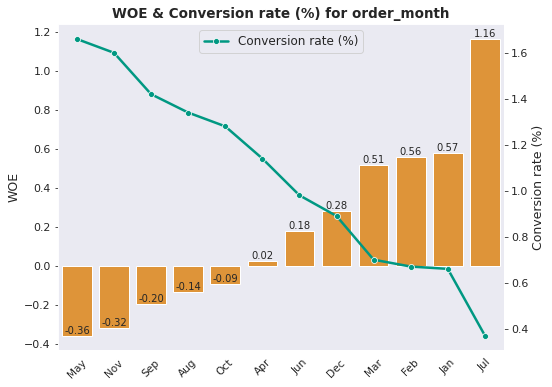

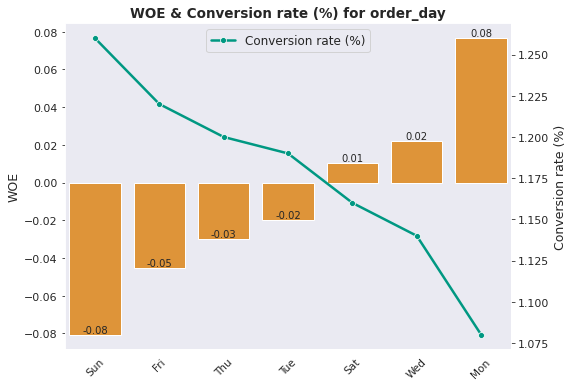

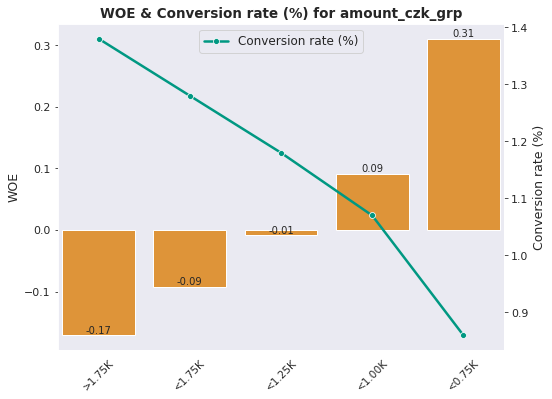

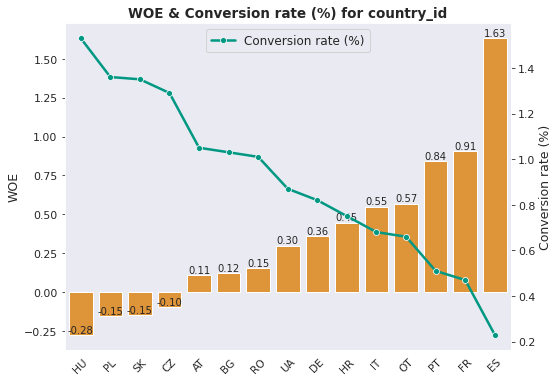

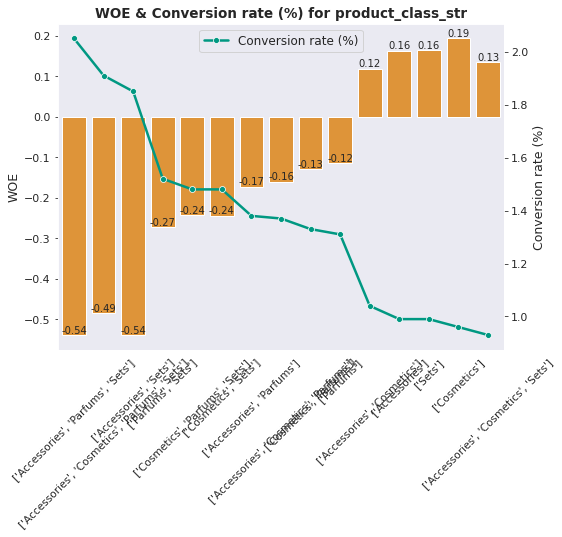

In [30]:
response = 'conversion'
predictors_nom = ['order_month', 'order_day', 'amount_czk_grp', 'country_id', 'product_class_str',
                  'gender', 'smpl_cat_in_prod_cat', 'perfume_in_product', 'perfume_in_sample',
                  'hair_in_product', 'hair_in_sample', 'makeup_in_product', 'makeup_in_sample',
                  'skin_in_product', 'skin_in_sample', 'body_in_product', 'body_in_sample',
                  'men_in_product', 'men_in_sample', 'flg_zero_frequency']
for i, predictor in enumerate(predictors_nom):
    if i < 5:
        woe = weight_of_evidence(train_sample=train, predictor=predictor, rotation=45,
                                 response=response, event_name='conversion', plot=True)
    else:
        woe = weight_of_evidence(train_sample=train, predictor=predictor, rotation=45,
                                 response=response, event_name='conversion', plot=False)
    train[predictor + '_woe'] = train.merge(woe, on=predictor, how='left')['woe']
    valid[predictor + '_woe'] = valid.merge(woe, on=predictor, how='left')['woe']
    test[predictor + '_woe'] = test.merge(woe, on=predictor, how='left')['woe']
    txn_smpl[predictor + '_woe'] = txn_smpl.merge(woe, on=predictor, how='left')['woe']

### 3.3 Model predictors and response variable definition


**Define model predictors and binary response** and check missing values for each predictor separately for each partition. **Binary response variable** `conversion` is defined as `1` if customer purchased any of the watched products within 120 days after its campaign transaction, otherwise it's defined as `0`. This definition of response variable makes the model interpretable as predicting the probability of a customer responding to the specific combination of samples distributed to him. Since the transactions conversions are calculated without excluding those customers who purchased the product before the camapign, the reported conversion rate used in the remaining part of this document is considered as `gross conversion rate` (`gcr`).

In [31]:
# Response variable
response = 'conversion'
# Nominal, WoE, Interval, Excluded, and (at least) Ordinal predictors
predictors_woe = [i + '_woe' for i in predictors_nom]
predictors_int = ['amount_czk', 'samples', 'products', 'watched_products_adj', 'categories_product',
                  'categories_sample', 'campaign_length', 'recency', 'frequency', 'monetary']
predictors_exc = ['category_product_str', 'category_sample_str']
predictors_ord = predictors_int + predictors_woe
predictors = predictors_nom + predictors_int + predictors_woe + predictors_exc

print(f"""PREDICTOR TYPE SUMMARY: \nNominal:     {len(predictors_nom)} \nInterval:    {len(predictors_int)} \
\nOrdinal/WoE: {len(predictors_woe)} \nExcluded:    {len(predictors_exc)} \nTotal:       {len(predictors)}""")

PREDICTOR TYPE SUMMARY: 
Nominal:     20 
Interval:    10 
Ordinal/WoE: 20 
Excluded:    2 
Total:       52


### 3.4 Missing values analysis

**Check missing values for each predictor** in each partition:

In [32]:
print('MISSING VALUES SUMMARY:')
print(pd.DataFrame(
    {'TRAIN': train[predictors].isnull().sum(), 
     'VALID': valid[predictors].isnull().sum(), 
     'TEST': test[predictors].isnull().sum()}))

MISSING VALUES SUMMARY:
                          TRAIN  VALID  TEST
order_month                   0      0     0
order_day                     0      0     0
amount_czk_grp                0      0     0
country_id                    0      0     0
product_class_str             0      0     0
gender                        0      0     0
smpl_cat_in_prod_cat          0      0     0
perfume_in_product            0      0     0
perfume_in_sample             0      0     0
hair_in_product               0      0     0
hair_in_sample                0      0     0
makeup_in_product             0      0     0
makeup_in_sample              0      0     0
skin_in_product               0      0     0
skin_in_sample                0      0     0
body_in_product               0      0     0
body_in_sample                0      0     0
men_in_product                0      0     0
men_in_sample                 0      0     0
flg_zero_frequency            0      0     0
amount_czk                    0

### 3.5 Univariate analysis of model predictors

**Univariate analysis - Somers'D performance (%),** measuring **for each predictor with at least ordinal measurement scale** (i.e. ordinal or interval type), its ordinal association with the response variable. **Somers'D coefficient (also known as Gini or Accuracy ratio) is closely related to AUROC** using the formula: `Somers'D = 2*AUROC-1`. We can see the strongest variables in the top of the list - it is expected they will be also significant in the predictive model. The sign of each Somers'D coefficient should be in line with business logic of predictor's  relationship with response variable (`conversion`). In this case, all non-woe coefficients are positive, which means that conversion rate (`gcr`) is positively correlated with all numerical predictors. **Predictors with insufficient rank ordering performance (the whole row highlighted in red) will be excluded from model shortlists.**

In [33]:
somersd_thrs = 0.091
somersd = univariate_analysis_somers_d(train_sample=train, 
                                       valid_sample=valid,
                                       test_sample=test, 
                                       total_sample=txn_smpl, 
                                       predictors=predictors_ord,   
                                       response=response,
                                       thrs=0.091)

Somers' D (%),train,valid,test,total
watched_products_adj,24.94%,24.41%,25.20%,24.89%
monetary,21.04%,21.90%,21.62%,21.33%
samples,20.96%,20.56%,22.04%,21.10%
frequency,20.31%,21.01%,20.66%,20.52%
order_month_woe,-18.61%,-18.76%,-18.65%,-18.65%
recency,-17.60%,-18.94%,-18.62%,-18.07%
perfume_in_sample_woe,-12.40%,-11.93%,-13.12%,-12.45%
country_id_woe,-12.22%,-12.04%,-11.49%,-12.04%
flg_zero_frequency_woe,-11.42%,-11.71%,-11.39%,-11.47%
skin_in_sample_woe,-11.22%,-10.98%,-11.50%,-11.23%


### 3.6 Multivariate analysis of model predictors

**Correlation matrix of ordinal and interval predictors that passed univariate analysis (Somers' D threshold)**. All absolute pairwise correlations are **less than or equal to 0.5** threshold, with two exceptions of `skin_in_sample_woe/perfume_in_sample_woe` and `monetary/frequency`. Because of this, only one predictor from each of these two pairs of predictors will be used in model shortlists so that the model does not suffer from multicollinearity.
To resolve this task, we decided to pick the higher-performing predictors in terms of Somers'D and therefore predictors `skin_in_sample` and `frequency` will be discarded in this phase.

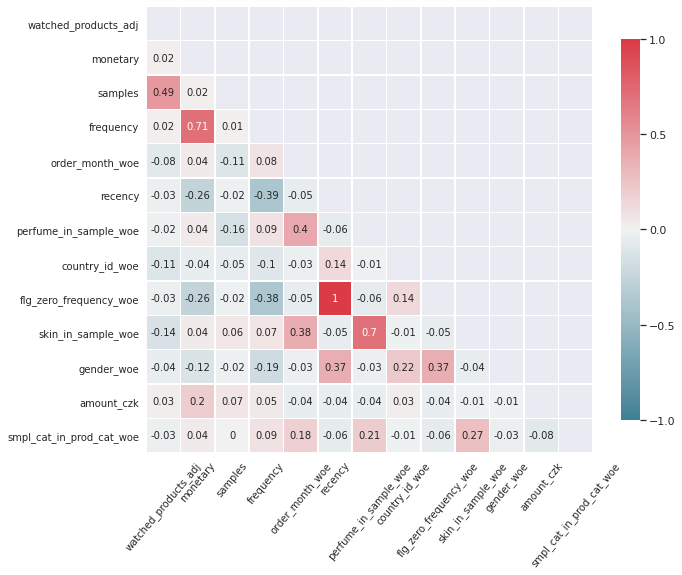

In [34]:
predictors_corr = somersd[abs(somersd.total) > somersd_thrs].index.values
correlation_matrix(train, predictors_corr)

## 4. Logistic regression

### 4.1 Shortlist of model predictors

**Define shortlist of predictors for model training** and narrow the development sample partitions to include only relevant columns - selected predictors and response. New datasets will be labeled `X_train`, `X_valid`, `X_test`, `y_train`, `y_valid`, `y_test`. 

In [35]:
shortlist = ['watched_products_adj',
             'samples',
             'order_month_woe',
             'perfume_in_sample_woe',
             'country_id_woe',
            ]
shortlist_cont = ['frequency', 'recency', 'amount_czk', 'watched_products']
shortlist_disc = ['samples', 'order_month', 'country_id', 'perfume_in_sample', 'gender', 'smpl_cat_in_prod_cat', 'flg_zero_frequency']

X_train, y_train = train[shortlist], train[response]
X_valid, y_valid = valid[shortlist], valid[response]
X_test, y_test = test[shortlist], test[response]

**Visualise each continuous and discrete (nominal, ordinal and count) predictor that made it into the final shortlist** against the conversion rate.

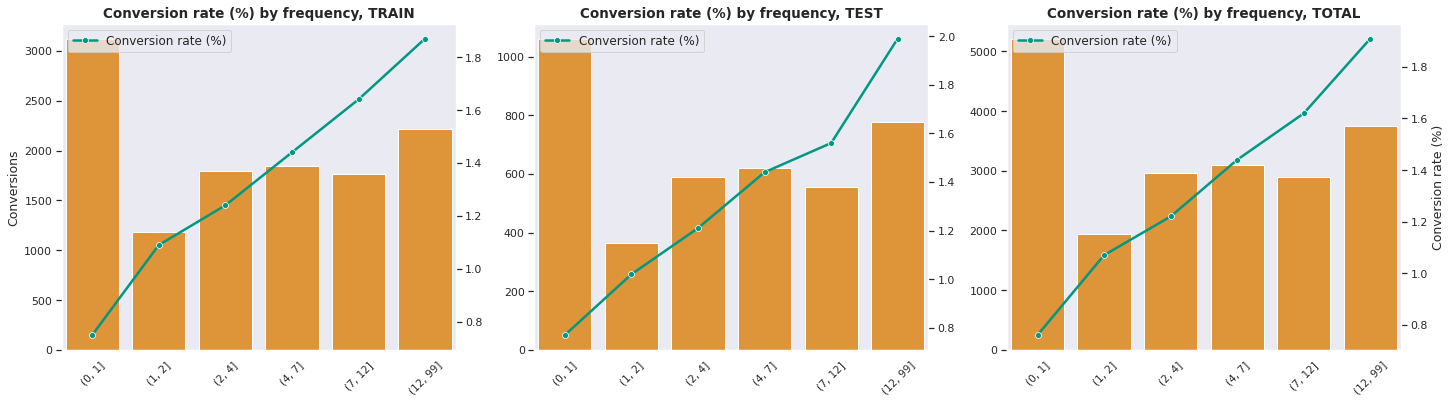

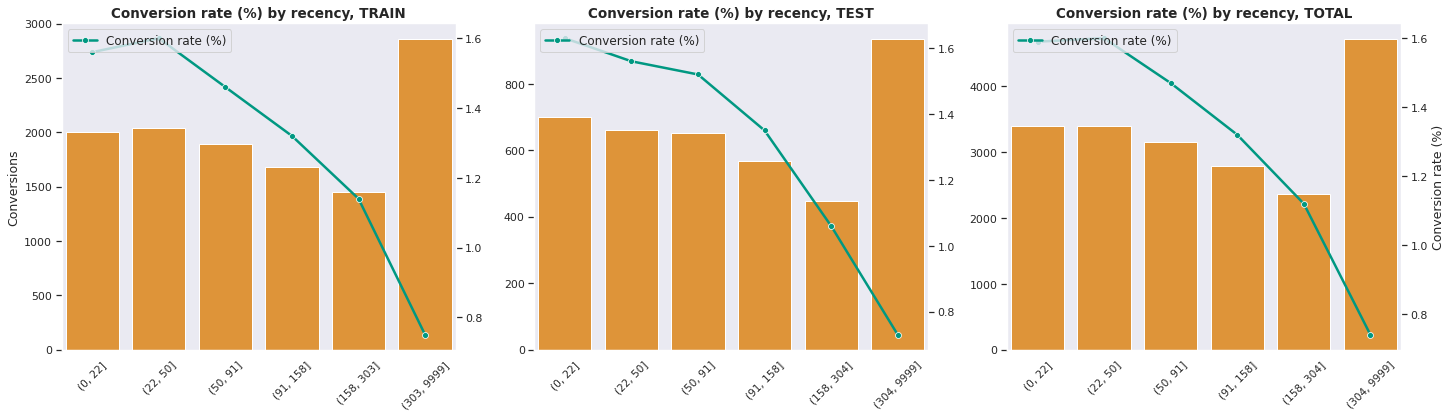

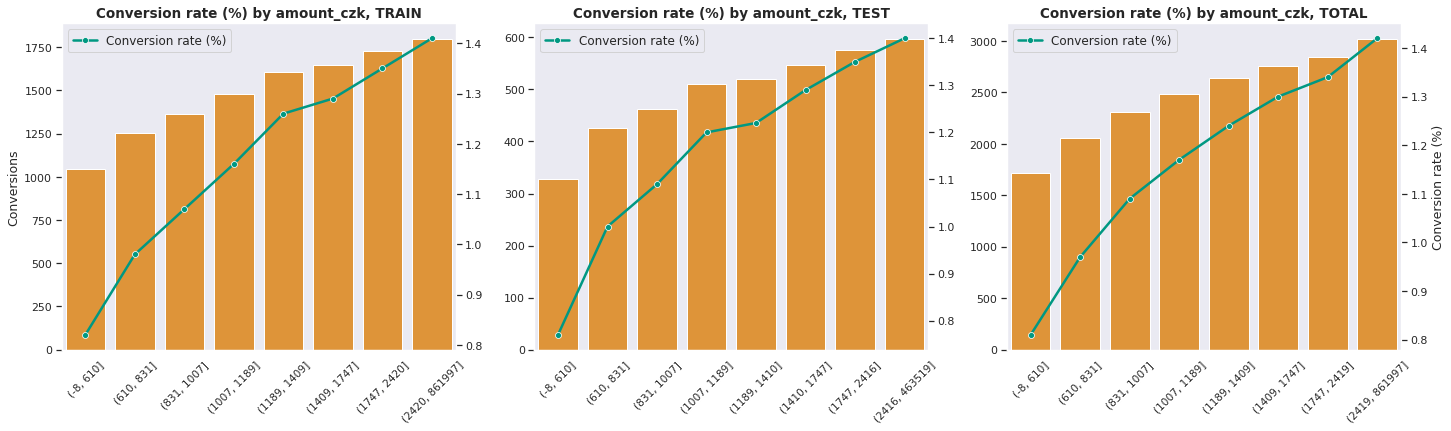

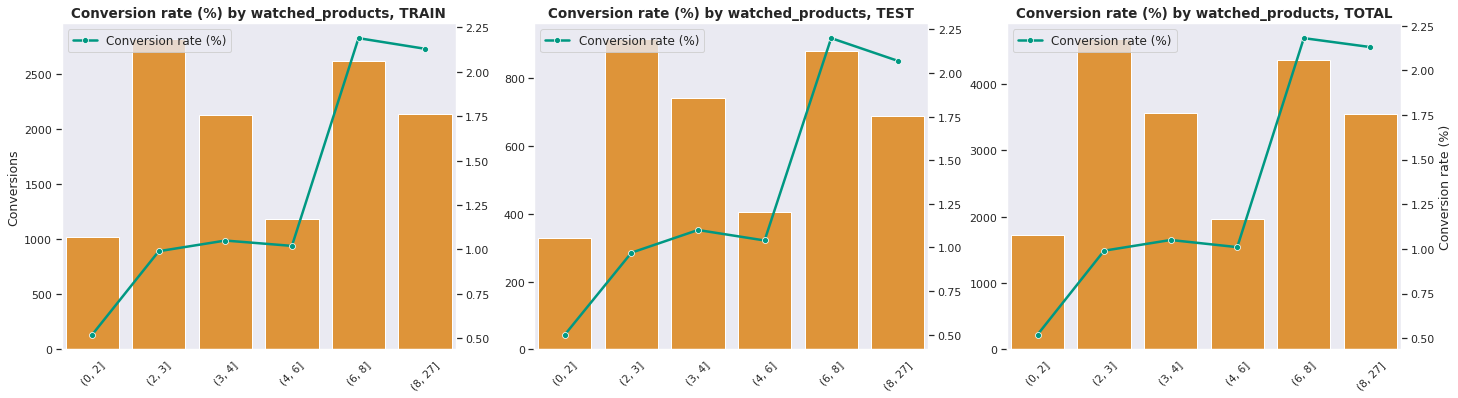

In [36]:
for predictor in shortlist_cont:
    univariate_analysis_continuous(train=train, 
                                   test=test,
                                   total=txn_smpl,
                                   response=response,
                                   predictor=predictor, 
                                   bins=8,
                                   event_name='conversion',
                                   event_rate_name='conversion_rate',
                                   rounding=0,
                                   rotation=45)

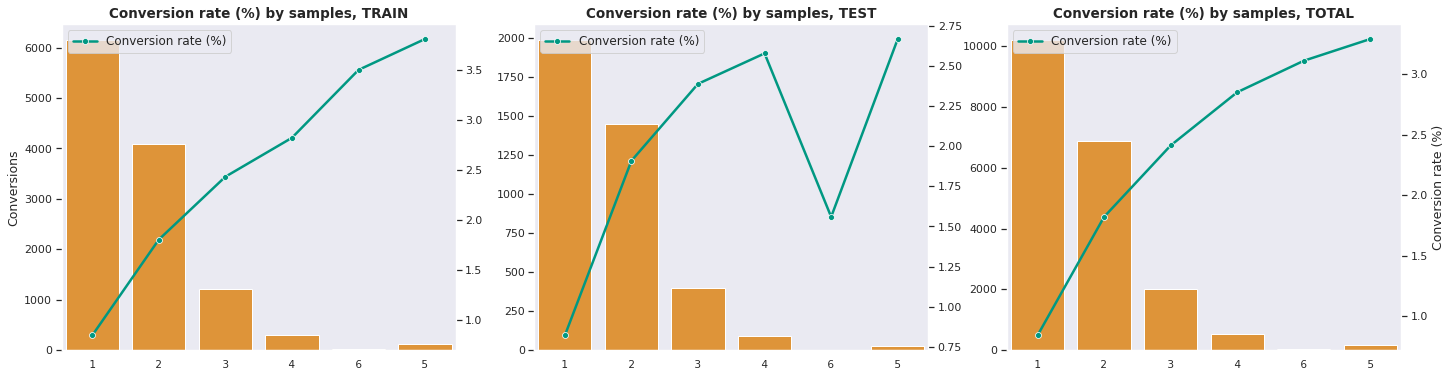

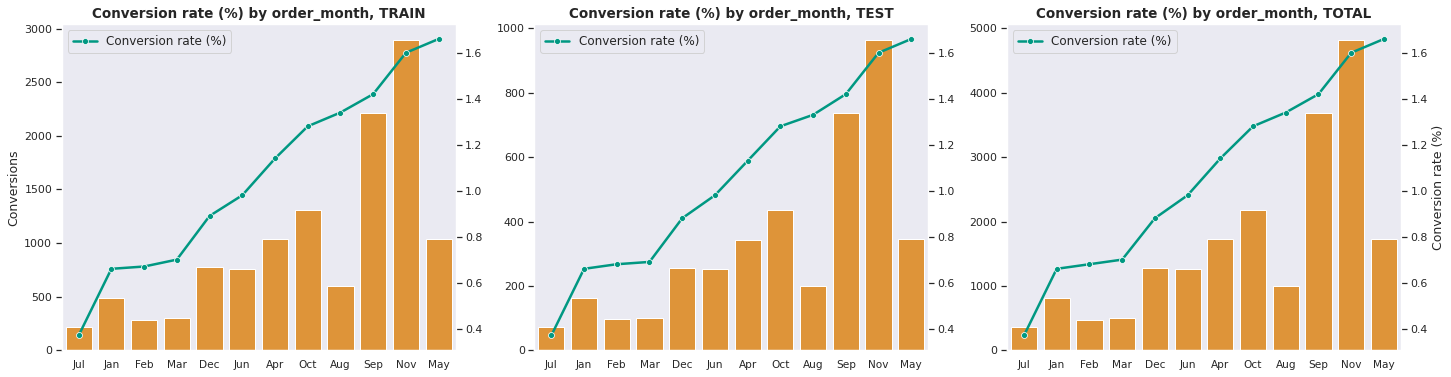

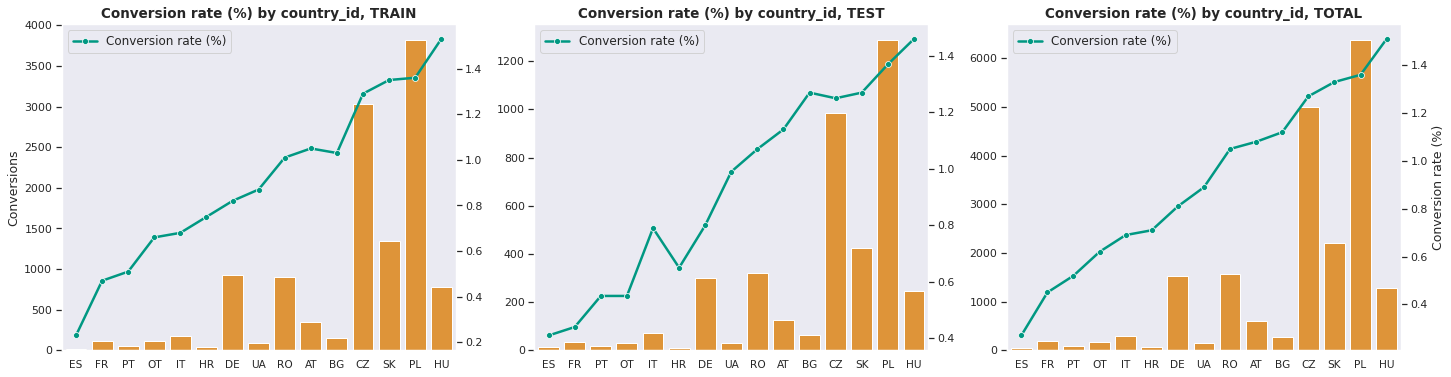

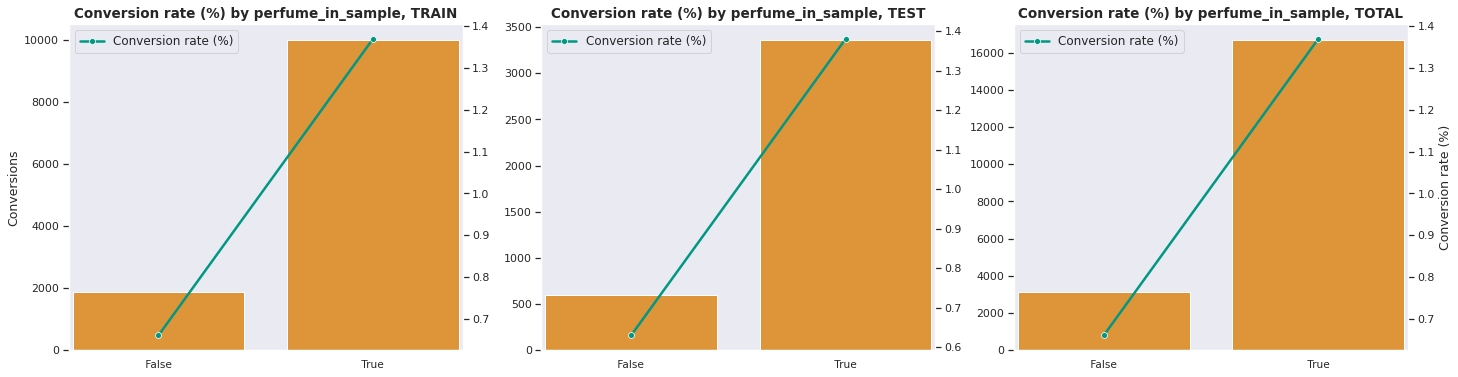

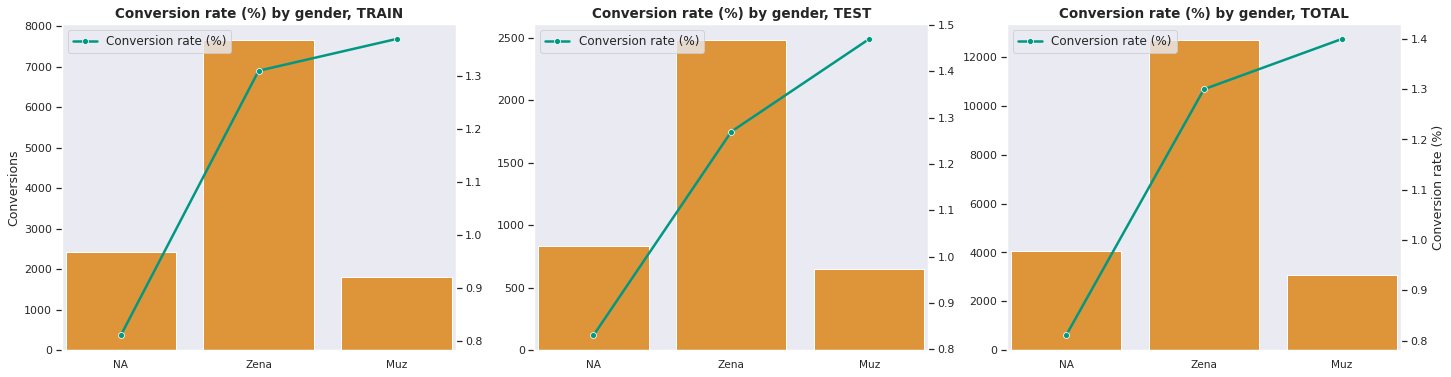

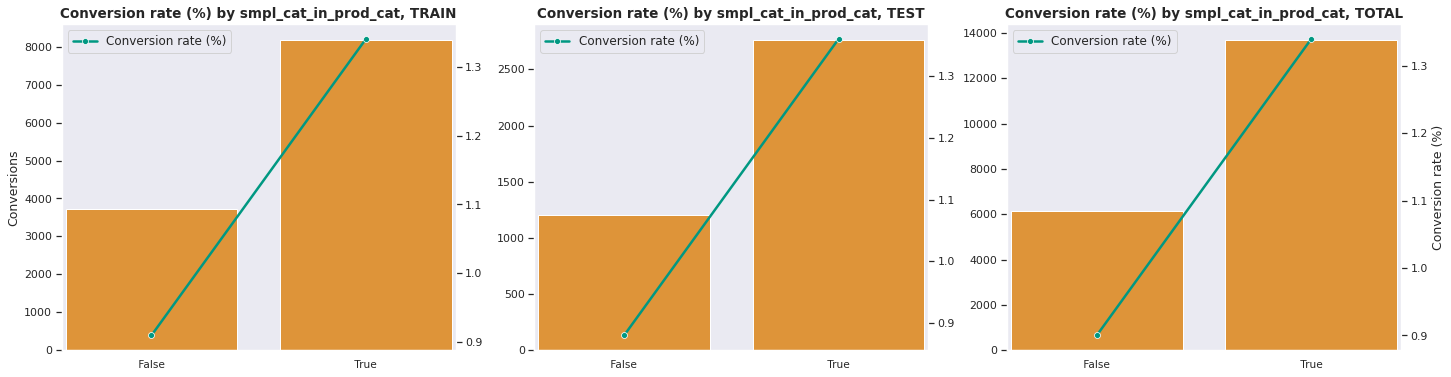

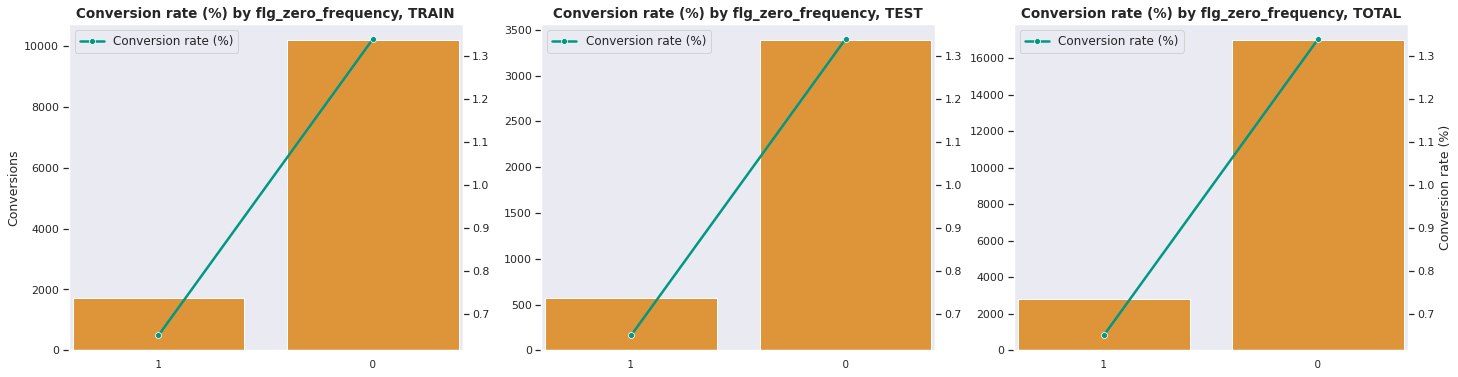

In [37]:
for predictor in shortlist_disc:
    univariate_analysis_categorical(train_sample=train, 
                                    test_sample=test,
                                    total_sample=txn_smpl,
                                    response=response, 
                                    predictor=predictor, 
                                    event_name='conversion', 
                                    event_rate_name='conversion_rate', 
                                    order_by='conversion_rate_total (%)',
                                    order_ascending=True,
                                    filter_sample_id='total', 
                                    prefix=' ',
                                    filter_object='conversion',
                                    filter_minimum=20, 
                                    rotation=0)

### 4.2 Standardization of predictors

**Standardize shortlist of predictors** transforming each variable to `mean = 0` and `std = 1`. Similarly as with missing values imputation, **standardization of testing sample** predictors `X_test` will be performed using `mean` and `scale` parameters calculated on **training sample**.

In [38]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train -= mean
X_train /= std
X_valid -= mean
X_valid /= std
X_test -= mean
X_test /= std

#np.save(file='pg_standardize_mean', arr=mean)
#np.save(file='pg_standardize_std', arr=std)

### 4.3 Fitting logistic regression model

**Statsmodels logistic regression model** - initialise and fit the logistic regression model on training sample using shortlist of predictors and calculate **coefficient estimates and the respective relative weights** of each predictor in the model. Note that weights are not calculated for `intercept` for which the weight is not defined. Also notable are the **signs of the coefficient estimates**. For all coefficients, **statistical interpretation is in line with the business logic**.

Optimization terminated successfully.
         Current function value: 0.061555
         Iterations 9


,coefficient_estimate,weight
const,-4.616055,0.00%
watched_products_adj,0.137722,12.31%
samples,0.206353,18.45%
order_month_woe,-0.288244,25.77%
perfume_in_sample_woe,-0.192571,17.21%
country_id_woe,-0.293750,26.26%


Log-likelihood:		 -62815.37 
AIC:			 125642.74 
Pseudo R-squared:	 0.032
Somers'D TRAIN:		 0.3324 
Somers'D VALID:		 0.328 
Somers'D TEST:		 0.3299
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.032      
Dependent Variable:    conversion        AIC:               125642.7372
Date:                  2021-03-25 11:53  BIC:               125713.7518
No. Observations:      1020470           Log-Likelihood:    -62815.    
Df Model:              5                 LL-Null:           -64870.    
Df Residuals:          1020464           LLR p-value:       0.0000     
Converged:             1.0000            Scale:             1.0000     
No. Iterations:        9.0000                                          
-----------------------------------------------------------------------
                       Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
const            

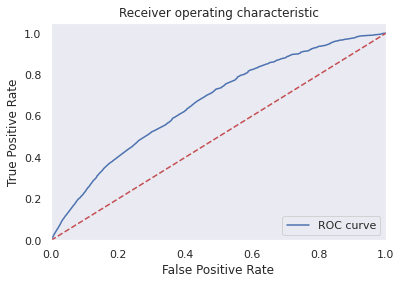

In [61]:
# mod_lr = LogisticRegression(solver='newton-cg', C=9999, max_iter=500, random_state=1)
# mod_lr.fit(X=X_train, y=y_train)
mod_lr = sm.Logit(y_train, sm.add_constant(X_train))
result = mod_lr.fit()

weights = pd.DataFrame((abs(result.params[1:])/abs(result.params[1:]).sum()), columns=['weight'])
coef = pd.DataFrame(result.params, columns=['coefficient_estimate'])
coefficient_estimates = coef.merge(weights, left_index=True, right_index=True, how='left')
coefficient_estimates.loc[['const'], 'weight']=0
display(coefficient_estimates.style.format({'weight': '{:,.2%}'}))

pred_prob_train = pd.Series(mod_lr.predict(result.params, sm.add_constant(X_train)), name='pc')
pred_prob_valid = pd.Series(mod_lr.predict(result.params, sm.add_constant(X_valid)), name='pc')
pred_prob_test = pd.Series(mod_lr.predict(result.params, sm.add_constant(X_test)), name='pc')

train_scored = pd.concat([train, pred_prob_train], axis=1)
valid_scored = pd.concat([valid, pred_prob_valid], axis=1)
test_scored = pd.concat([test, pred_prob_test], axis=1)

somers_d_train = round(2*m.roc_auc_score(train_scored[response], train_scored.pc)-1, 4)
somers_d_valid = round(2*m.roc_auc_score(valid_scored[response], valid_scored.pc)-1, 4)
somers_d_test = round(2*m.roc_auc_score(test_scored[response], test_scored.pc)-1, 4)

print('Log-likelihood:\t\t', round(result.llf,2), '\nAIC:\t\t\t', round(result.aic,2), '\nPseudo R-squared:\t', round(result.prsquared,3))
print('Somers\'D TRAIN:\t\t', somers_d_train, '\nSomers\'D VALID:\t\t', somers_d_valid, '\nSomers\'D TEST:\t\t', somers_d_test)
display_roc_curve(train_scored[response], train_scored.pc);
print(result.summary2())

### 4.4 Precision/recall evaluation on test set

               precision    recall  f1-score   support

Non-Converted       0.99      0.80      0.89    336192
    Converted       0.02      0.40      0.04      3965

     accuracy                           0.80    340157
    macro avg       0.51      0.60      0.47    340157
 weighted avg       0.98      0.80      0.88    340157

Actual precision: 2.34% 
Actual recall:   40.20%


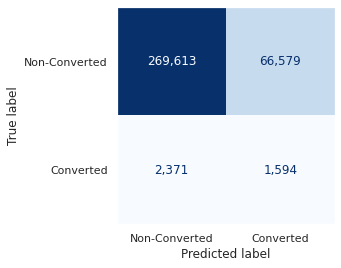

In [62]:
threshold = 0.015
labels = ['Non-Converted', 'Converted']
cm = classification_table(test_scored[response], test_scored.pc, threshold=threshold)
plot_confusion_matrix(cm, display_labels=labels);
classification_statistics(test_scored[response], test_scored.pc, threshold=threshold, target_names=['Non-Converted', 'Converted'])
print(f'Actual precision: {1594/(1594+66579):,.2%} \nActual recall:   {1594/(1594+2371):,.2%}')

Other possible predictor combinations successful at increasing conversion rate can be found by running the following best subset algorithm upon the shortlist of predictors.

In [ ]:
res = logreg_best_subset(train=train, 
                         valid=valid,
                         test=test, 
                         predictors=shortlist,
                         first=5, 
                         response=response,
                         threshold=0.015,
                         best_p_subset_criterion='train_precision',
                         prediction='pc',
                         order_ascending=True)

# res = pd.HDFStore('./hdf5/smpl/logreg_results.h5').res
# res = res.reset_index()
# res['without_history'] = res['index'].apply(lambda x: 0 if 'recency' in x or 'frequency' in x or 'monetary' in x or 'flg_zero_frequency_woe' in x else 1)
# res[res.without_history == 1].sort_values('train_precision', ascending=False).head(70).style.format({**fmt_pct, **fmt_int})

## 5. Decision tree

### 5.1 Shortlist of model predictors without any history-related predictors

**Define shortlist of predictors for model training** and narrow the development sample partitions to include only relevant columns - selected predictors and response. New datasets will be labeled `X_train`, `X_valid`, `X_test`, `y_train`, `y_valid`, `y_test`. 

In [63]:
shortlist_full = ['watched_products_adj', 'samples', 'order_month_woe', 'perfume_in_sample_woe', 'country_id_woe',
                  'frequency', 'recency', 'amount_czk', 'gender_woe', 'flg_zero_frequency_woe', 'smpl_cat_in_prod_cat']
shortlist_wh = ['watched_products_adj', 'samples', 'order_month_woe', 'perfume_in_sample_woe', 'country_id_woe']
shortlist = shortlist_wh

X_train, y_train = train[shortlist], train[response]
X_valid, y_valid = valid[shortlist], valid[response]
X_test, y_test = test[shortlist], test[response]

### 5.2 Fitting decision tree model 

Somers'D TRAIN:		 0.3524 
Somers'D VALID:		 0.3437 
Somers'D TEST:		 0.3473


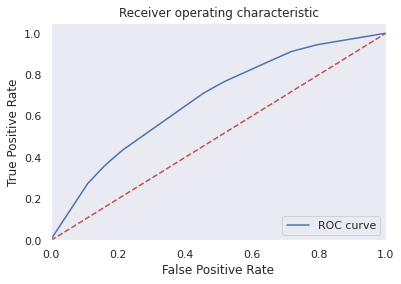

In [64]:
mod_dt = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_split=100, max_features=None, random_state=1)
mod_dt.fit(X_train, y_train)

pred_prob_train = pd.Series(mod_dt.predict_proba(X_train)[:,1], name='pc')
pred_prob_valid = pd.Series(mod_dt.predict_proba(X_valid)[:, 1], name='pc')
pred_prob_test = pd.Series(mod_dt.predict_proba(X_test)[:, 1], name='pc')

train_scored = pd.concat([train, pred_prob_train], axis=1)
valid_scored = pd.concat([valid, pred_prob_valid], axis=1)
test_scored = pd.concat([test, pred_prob_test], axis=1)

somers_d_train = round(2*m.roc_auc_score(train_scored[response], train_scored.pc)-1, 4)
somers_d_valid = round(2*m.roc_auc_score(valid_scored[response], valid_scored.pc)-1, 4)
somers_d_test = round(2*m.roc_auc_score(test_scored[response], test_scored.pc)-1, 4)

print('Somers\'D TRAIN:\t\t', somers_d_train, '\nSomers\'D VALID:\t\t', somers_d_valid, '\nSomers\'D TEST:\t\t', somers_d_test)
display_roc_curve(train_scored[response], train_scored.pc);

### 5.3 Precision/recall evaluation on test set

               precision    recall  f1-score   support

Non-Converted       0.99      0.78      0.88    336192
    Converted       0.02      0.44      0.04      3965

     accuracy                           0.78    340157
    macro avg       0.51      0.61      0.46    340157
 weighted avg       0.98      0.78      0.87    340157

Actual TEST precision: 2.34% 
Actual TEST recall:   43.93%


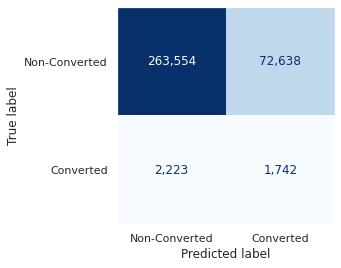

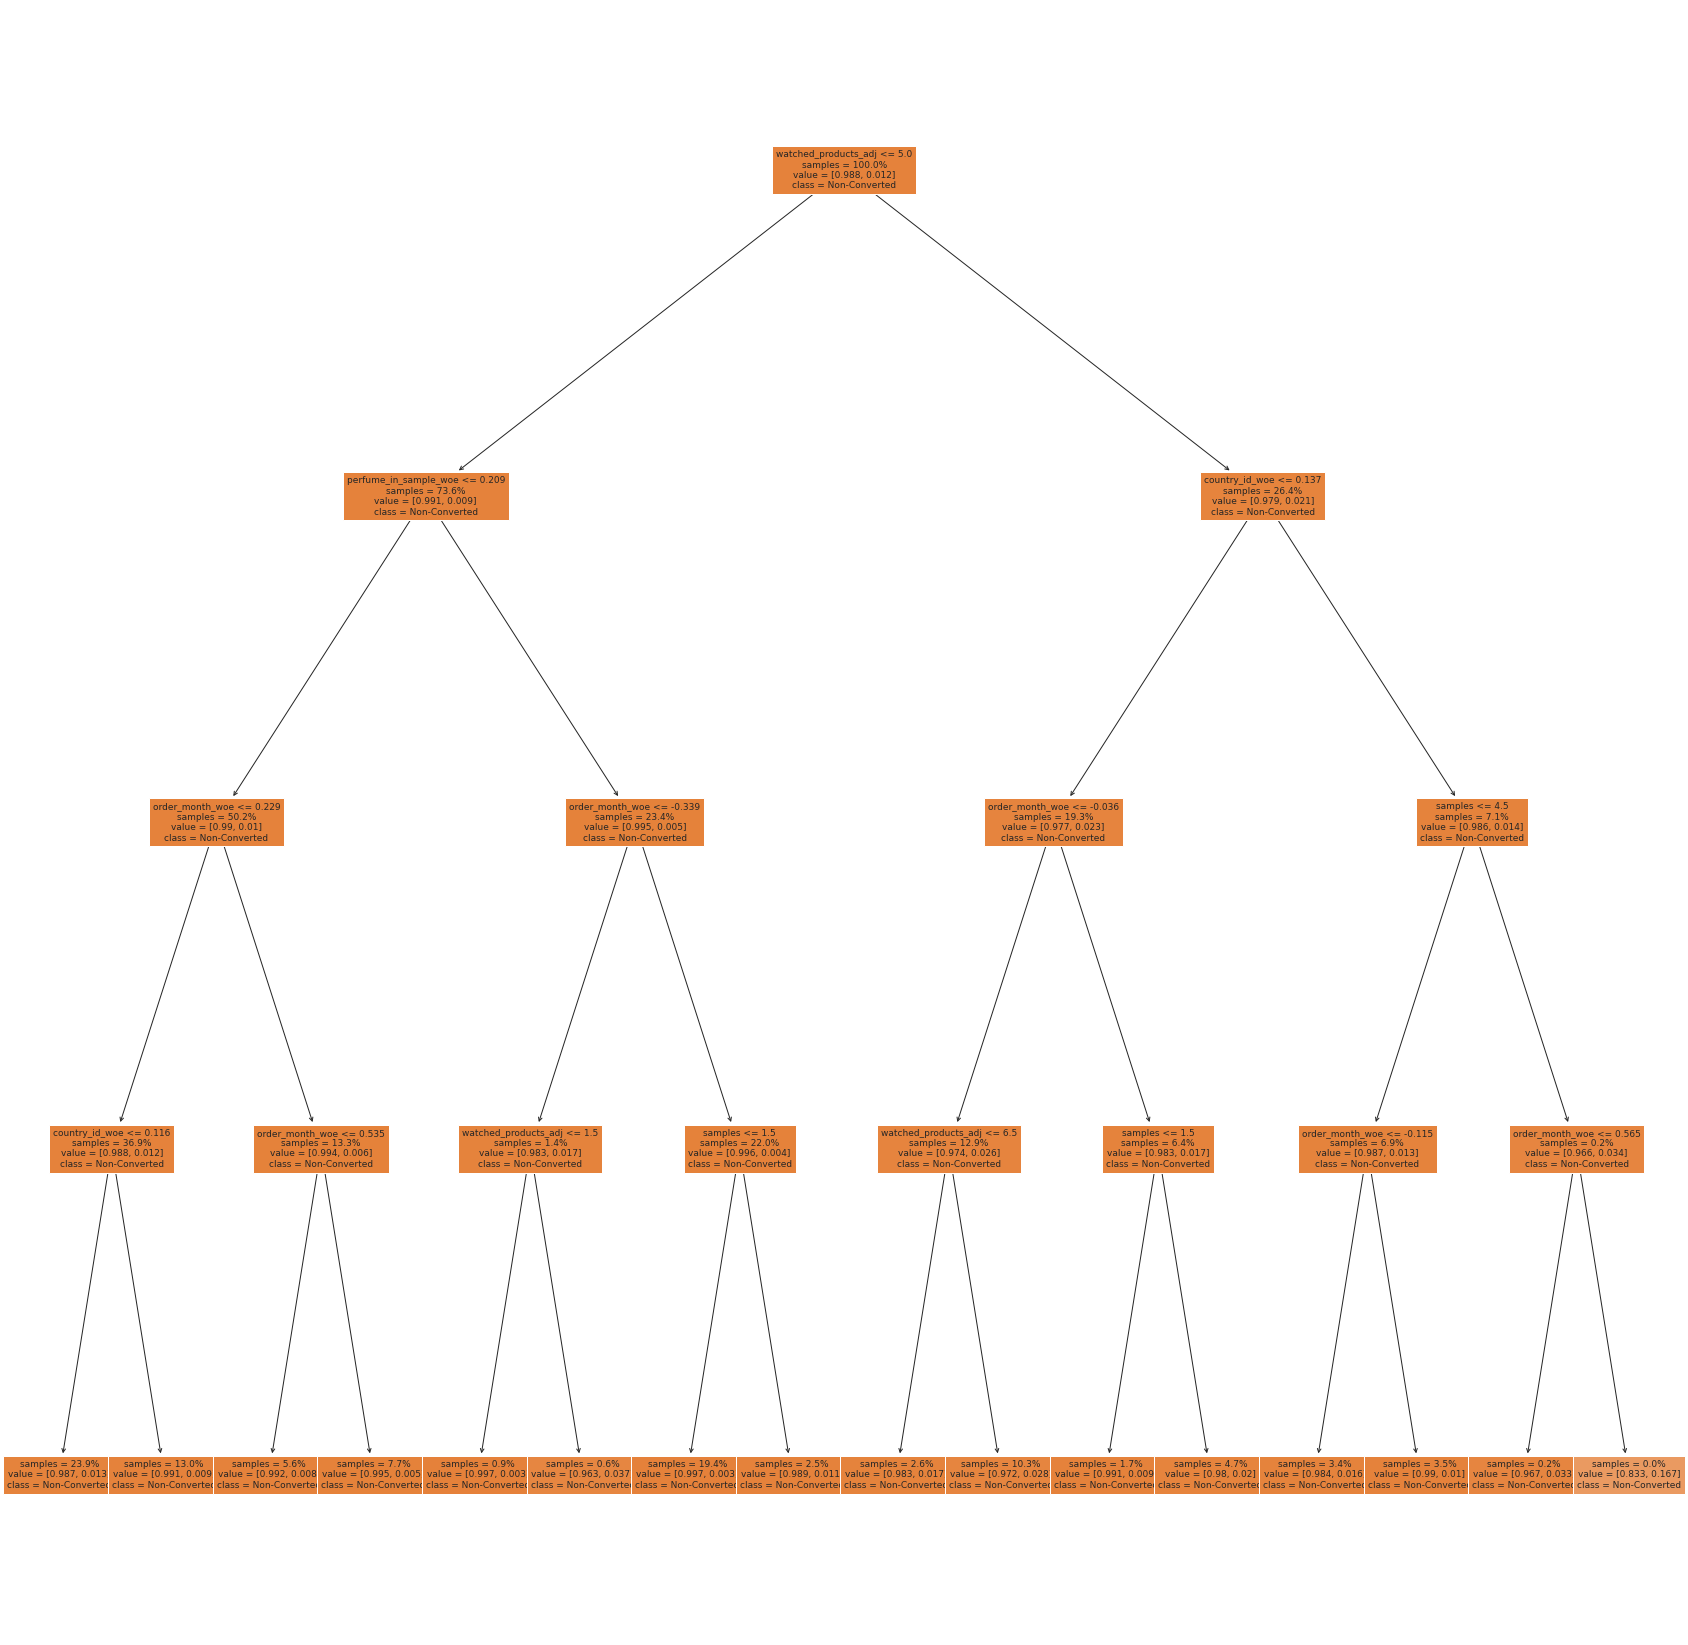

In [65]:
threshold = 0.015
labels = ['Non-Converted', 'Converted']
cm = classification_table(test_scored[response], test_scored.pc, threshold=threshold)
plot_confusion_matrix(cm, display_labels=labels);
classification_statistics(test_scored[response], test_scored.pc, threshold=threshold, target_names=['Non-Converted', 'Converted'])
print(f'Actual TEST precision: {cm[1][1]/(cm[1][1]+cm[0][1]):,.2%} \nActual TEST recall:   {cm[1][1]/(cm[1][1]+cm[1][0]):,.2%}')
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
plot_tree(mod_dt, fontsize=9, feature_names=shortlist, impurity=False, class_names=labels, proportion=True, filled=True, ax=ax)
plt.show()

### 5.4 Shortlist of model predictors with history-related predictors

**Define shortlist of predictors for model training** and narrow the development sample partitions to include only relevant columns - selected predictors and response. New datasets will be labeled `X_train`, `X_valid`, `X_test`, `y_train`, `y_valid`, `y_test`. 

In [556]:
shortlist_full = ['watched_products_adj', 'samples', 'order_month_woe', 'perfume_in_sample_woe', 'country_id_woe',
                  'frequency', 'recency', 'amount_czk', 'gender_woe', 'flg_zero_frequency_woe', 'smpl_cat_in_prod_cat']
shortlist_wh = ['watched_products_adj', 'samples', 'order_month_woe', 'perfume_in_sample_woe', 'country_id_woe']
shortlist = shortlist_full

X_train, y_train = train[shortlist], train[response]
X_valid, y_valid = valid[shortlist], valid[response]
X_test, y_test = test[shortlist], test[response]

### 5.5 Fitting decision tree model 

Somers'D TRAIN:		 0.3762 
Somers'D VALID:		 0.3699 
Somers'D TEST:		 0.3758


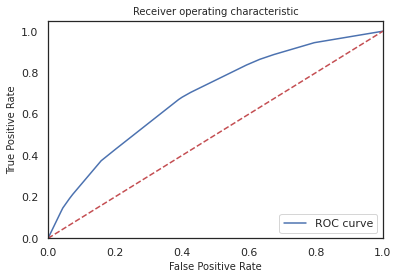

In [557]:
mod_dt = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_split=100, max_features=None, random_state=1)
mod_dt.fit(X_train, y_train)

pred_prob_train = pd.Series(mod_dt.predict_proba(X_train)[:,1], name='pc')
pred_prob_valid = pd.Series(mod_dt.predict_proba(X_valid)[:, 1], name='pc')
pred_prob_test = pd.Series(mod_dt.predict_proba(X_test)[:, 1], name='pc')

train_scored = pd.concat([train, pred_prob_train], axis=1)
valid_scored = pd.concat([valid, pred_prob_valid], axis=1)
test_scored = pd.concat([test, pred_prob_test], axis=1)

somers_d_train = round(2*m.roc_auc_score(train_scored[response], train_scored.pc)-1, 4)
somers_d_valid = round(2*m.roc_auc_score(valid_scored[response], valid_scored.pc)-1, 4)
somers_d_test = round(2*m.roc_auc_score(test_scored[response], test_scored.pc)-1, 4)

print('Somers\'D TRAIN:\t\t', somers_d_train, '\nSomers\'D VALID:\t\t', somers_d_valid, '\nSomers\'D TEST:\t\t', somers_d_test)
display_roc_curve(train_scored[response], train_scored.pc);

### 5.6 Precision/recall evaluation on test set

               precision    recall  f1-score   support

Non-Converted       0.99      0.80      0.88    336192
    Converted       0.02      0.44      0.05      3965

     accuracy                           0.79    340157
    macro avg       0.51      0.62      0.47    340157
 weighted avg       0.98      0.79      0.87    340157

Actual TEST precision: 2.50% 
Actual TEST recall:   43.93%


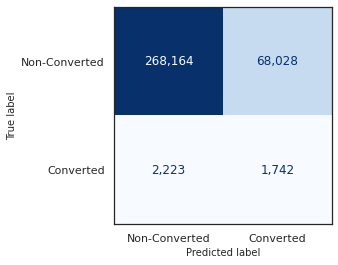

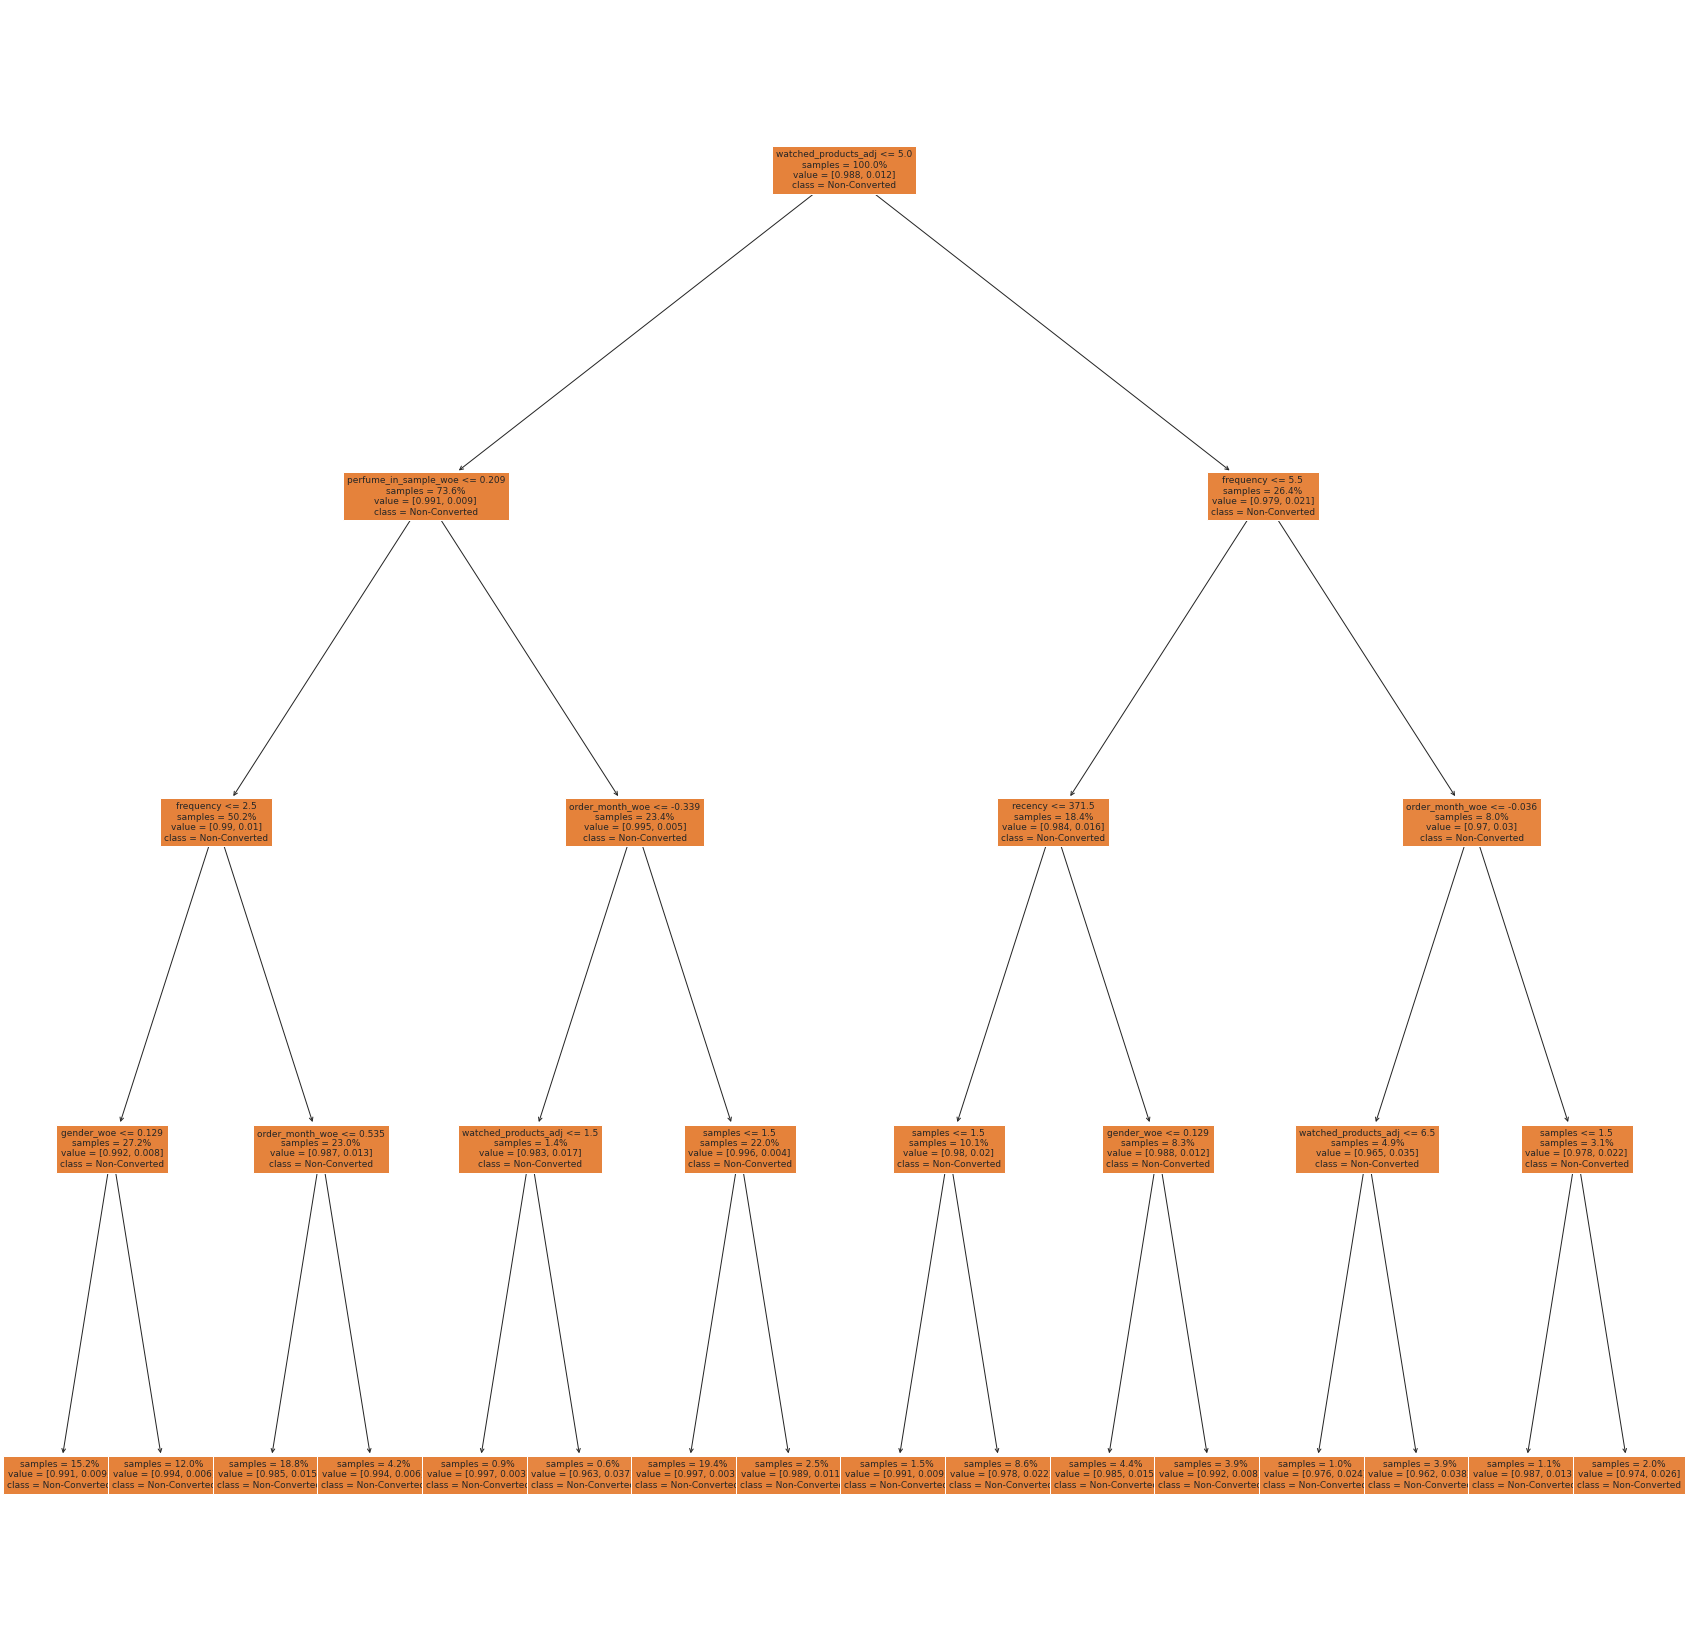

In [558]:
threshold = 0.015
labels = ['Non-Converted', 'Converted']
cm = classification_table(test_scored[response], test_scored.pc, threshold=threshold)
plot_confusion_matrix(cm, display_labels=labels);
classification_statistics(test_scored[response], test_scored.pc, threshold=threshold, target_names=['Non-Converted', 'Converted'])
print(f'Actual TEST precision: {cm[1][1]/(cm[1][1]+cm[0][1]):,.2%} \nActual TEST recall:   {cm[1][1]/(cm[1][1]+cm[1][0]):,.2%}')
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
plot_tree(mod_dt, fontsize=9, feature_names=shortlist, impurity=False, class_names=labels, proportion=True, filled=True, ax=ax)
plt.show()

## 6. Random forest

### 6.1 Shortlist of model predictors without any history-related predictors

**Define shortlist of predictors for model training** and narrow the development sample partitions to include only relevant columns - selected predictors and response. New datasets will be labeled `X_train`, `X_valid`, `X_test`, `y_train`, `y_valid`, `y_test`. 

In [560]:
shortlist_full = ['watched_products_adj', 'samples', 'order_month_woe', 'perfume_in_sample_woe', 'country_id_woe',
                  'frequency', 'recency', 'amount_czk', 'gender_woe', 'flg_zero_frequency_woe', 'smpl_cat_in_prod_cat']
shortlist_wh = ['watched_products_adj', 'samples', 'order_month_woe', 'perfume_in_sample_woe', 'country_id_woe']
shortlist = shortlist_wh

X_train, y_train = train[shortlist], train[response]
X_valid, y_valid = valid[shortlist], valid[response]
X_test, y_test = test[shortlist], test[response]

### 6.2 Fitting random forest model 

Somers'D TRAIN:		 0.3651 
Somers'D VALID:		 0.3573 
Somers'D TEST:		 0.3651


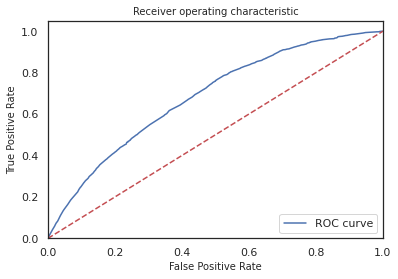

In [568]:
mod_dt = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4, min_samples_split=1000, oob_score=True, random_state=1)
mod_dt.fit(X_train, y_train)

pred_prob_train = pd.Series(mod_dt.predict_proba(X_train)[:,1], name='pc')
pred_prob_valid = pd.Series(mod_dt.predict_proba(X_valid)[:, 1], name='pc')
pred_prob_test = pd.Series(mod_dt.predict_proba(X_test)[:, 1], name='pc')

train_scored = pd.concat([train, pred_prob_train], axis=1)
valid_scored = pd.concat([valid, pred_prob_valid], axis=1)
test_scored = pd.concat([test, pred_prob_test], axis=1)

somers_d_train = round(2*m.roc_auc_score(train_scored[response], train_scored.pc)-1, 4)
somers_d_valid = round(2*m.roc_auc_score(valid_scored[response], valid_scored.pc)-1, 4)
somers_d_test = round(2*m.roc_auc_score(test_scored[response], test_scored.pc)-1, 4)

print('Somers\'D TRAIN:\t\t', somers_d_train, '\nSomers\'D VALID:\t\t', somers_d_valid, '\nSomers\'D TEST:\t\t', somers_d_test)
display_roc_curve(train_scored[response], train_scored.pc);

### 6.3 Precision/recall evaluation on test set

               precision    recall  f1-score   support

Non-Converted       0.99      0.78      0.87    336192
    Converted       0.02      0.45      0.04      3965

     accuracy                           0.77    340157
    macro avg       0.51      0.61      0.46    340157
 weighted avg       0.98      0.77      0.86    340157

Actual TEST precision: 2.31% 
Actual TEST recall:   44.97%


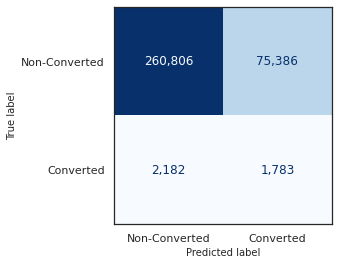

In [569]:
threshold = 0.015
labels = ['Non-Converted', 'Converted']
cm = classification_table(test_scored[response], test_scored.pc, threshold=threshold)
plot_confusion_matrix(cm, display_labels=labels);
classification_statistics(test_scored[response], test_scored.pc, threshold=threshold, target_names=['Non-Converted', 'Converted'])
print(f'Actual TEST precision: {cm[1][1]/(cm[1][1]+cm[0][1]):,.2%} \nActual TEST recall:   {cm[1][1]/(cm[1][1]+cm[1][0]):,.2%}')

### 6.4 Shortlist of model predictors with history-related predictors

**Define shortlist of predictors for model training** and narrow the development sample partitions to include only relevant columns - selected predictors and response. New datasets will be labeled `X_train`, `X_valid`, `X_test`, `y_train`, `y_valid`, `y_test`. 

In [55]:
shortlist_full = ['watched_products_adj', 'samples', 'order_month_woe', 'perfume_in_sample_woe', 'country_id_woe',
                  'frequency', 'recency', 'amount_czk', 'gender_woe', 'flg_zero_frequency_woe', 'smpl_cat_in_prod_cat']
shortlist_wh = ['watched_products_adj', 'samples', 'order_month_woe', 'perfume_in_sample_woe', 'country_id_woe']
shortlist = shortlist_full

X_train, y_train = train[shortlist], train[response]
X_valid, y_valid = valid[shortlist], valid[response]
X_test, y_test = test[shortlist], test[response]

### 6.5 Fitting random forest model 

Somers'D TRAIN:		 0.4071 
Somers'D VALID:		 0.4043 
Somers'D TEST:		 0.4088


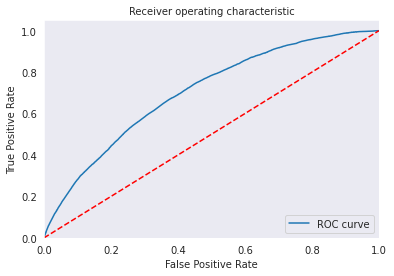

In [57]:
mod_dt = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=4, min_samples_split=1000, oob_score=True, random_state=1)
mod_dt.fit(X_train, y_train)

pred_prob_train = pd.Series(mod_dt.predict_proba(X_train)[:,1], name='pc')
pred_prob_valid = pd.Series(mod_dt.predict_proba(X_valid)[:, 1], name='pc')
pred_prob_test = pd.Series(mod_dt.predict_proba(X_test)[:, 1], name='pc')

train_scored = pd.concat([train, pred_prob_train], axis=1)
valid_scored = pd.concat([valid, pred_prob_valid], axis=1)
test_scored = pd.concat([test, pred_prob_test], axis=1)

somers_d_train = round(2*roc_auc_score(train_scored[response], train_scored.pc)-1, 4)
somers_d_valid = round(2*roc_auc_score(valid_scored[response], valid_scored.pc)-1, 4)
somers_d_test = round(2*roc_auc_score(test_scored[response], test_scored.pc)-1, 4)

print('Somers\'D TRAIN:\t\t', somers_d_train, '\nSomers\'D VALID:\t\t', somers_d_valid, '\nSomers\'D TEST:\t\t', somers_d_test)
display_roc_curve(train_scored[response], train_scored.pc);

### 6.6 Precision/recall evaluation on test set

               precision    recall  f1-score   support

Non-Converted       0.99      0.80      0.88    336192
    Converted       0.03      0.45      0.05      3965

     accuracy                           0.79    340157
    macro avg       0.51      0.62      0.47    340157
 weighted avg       0.98      0.79      0.87    340157

Actual TEST precision: 2.56% 
Actual TEST recall:   45.02%


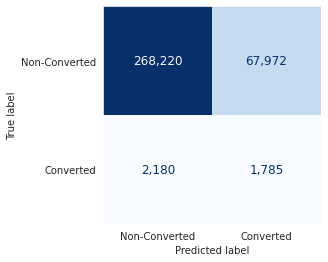

In [58]:
threshold = 0.015
labels = ['Non-Converted', 'Converted']
cm = classification_table(test_scored[response], test_scored.pc, threshold=threshold)
plot_confusion_matrix(cm, display_labels=labels);
classification_statistics(test_scored[response], test_scored.pc, threshold=threshold, target_names=['Non-Converted', 'Converted'])
print(f'Actual TEST precision: {cm[1][1]/(cm[1][1]+cm[0][1]):,.2%} \nActual TEST recall:   {cm[1][1]/(cm[1][1]+cm[1][0]):,.2%}')

## 7. CatBoost (Categorical Boosting)

### 7.1 Shortlist of model predictors with history-related predictors

**Define shortlist of predictors for model training** and narrow the development sample partitions to include only relevant columns - selected predictors and response. New datasets will be labeled `X_train`, `X_valid`, `X_test`, `y_train`, `y_valid`, `y_test`. 

In [48]:
shortlist_full = ['watched_products_adj', 'samples', 'order_month', 'perfume_in_sample', 'country_id',
                  'frequency', 'recency', 'amount_czk', 'gender', 'flg_zero_frequency', 'smpl_cat_in_prod_cat']
shortlist_wh = ['watched_products_adj', 'samples', 'order_month_woe', 'perfume_in_sample_woe', 'country_id_woe']
shortlist = shortlist_full

X_train, y_train = train[shortlist], train[response]
X_valid, y_valid = valid[shortlist], valid[response]
X_test, y_test = test[shortlist], test[response]

### 7.2 Fitting catboost model 

In [49]:
mod_cb = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5,  random_seed=1)
mod_cb.fit(X_train, y_train, cat_features=[2,3,4,8,9,10],  logging_level='Silent')

Somers'D TRAIN:		 0.4278 
Somers'D VALID:		 0.4241 
Somers'D TEST:		 0.4284


array([1.11371921e+00, 1.13719215e-01, 1.01722561e-01, ...,
       1.10288609e-03, 1.10179465e-03, 1.10091157e-03])

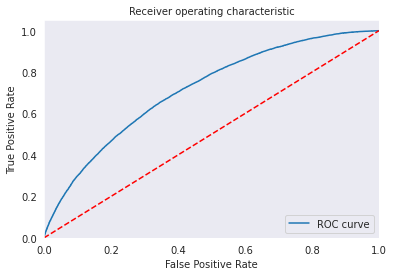

In [50]:
pred_prob_train = pd.Series(mod_cb.predict_proba(X_train)[:,1], name='pc')
pred_prob_valid = pd.Series(mod_cb.predict_proba(X_valid)[:, 1], name='pc')
pred_prob_test = pd.Series(mod_cb.predict_proba(X_test)[:, 1], name='pc')

train_scored = pd.concat([train, pred_prob_train], axis=1)
valid_scored = pd.concat([valid, pred_prob_valid], axis=1)
test_scored = pd.concat([test, pred_prob_test], axis=1)

somers_d_train = round(2*roc_auc_score(train_scored[response], train_scored.pc)-1, 4)
somers_d_valid = round(2*roc_auc_score(valid_scored[response], valid_scored.pc)-1, 4)
somers_d_test = round(2*roc_auc_score(test_scored[response], test_scored.pc)-1, 4)

print('Somers\'D TRAIN:\t\t', somers_d_train, '\nSomers\'D VALID:\t\t', somers_d_valid, '\nSomers\'D TEST:\t\t', somers_d_test)
display_roc_curve(train_scored[response], train_scored.pc)

### 7.3 Precision/recall evaluation on test set

Actual TEST precision:  2.79% 
Actual TEST recall:    44.26%
Actual TRAIN precision: 2.79% 
Actual TRAIN recall:   43.98%
Actual VALID precision: 2.72% 
Actual VALID recall:   42.97%
               precision    recall  f1-score   support

Non-Converted       0.99      0.82      0.90    336192
    Converted       0.03      0.44      0.05      3965

     accuracy                           0.81    340157
    macro avg       0.51      0.63      0.47    340157
 weighted avg       0.98      0.81      0.89    340157



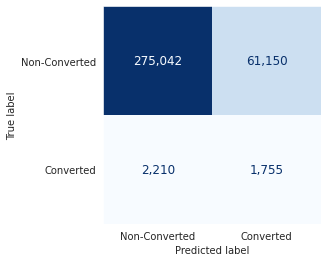

In [54]:
threshold = 0.017
labels = ['Non-Converted', 'Converted']
cm_train = classification_table(train_scored[response], train_scored.pc, threshold=threshold)
cm_valid = classification_table(valid_scored[response], valid_scored.pc, threshold=threshold)
cm_test = classification_table(test_scored[response], test_scored.pc, threshold=threshold)

print(f'Actual TEST precision:  {cm_test[1][1]/(cm_test[1][1]+cm_test[0][1]):,.2%} \nActual TEST recall:    {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):,.2%}')
print(f'Actual TRAIN precision: {cm_train[1][1]/(cm_train[1][1]+cm_train[0][1]):,.2%} \nActual TRAIN recall:   {cm_train[1][1]/(cm_train[1][1]+cm_train[1][0]):,.2%}')
print(f'Actual VALID precision: {cm_valid[1][1]/(cm_valid[1][1]+cm_valid[0][1]):,.2%} \nActual VALID recall:   {cm_valid[1][1]/(cm_valid[1][1]+cm_valid[1][0]):,.2%}')

plot_confusion_matrix(cm_test, display_labels=labels);
classification_statistics(test_scored[response], test_scored.pc, threshold=threshold, target_names=['Non-Converted', 'Converted'])

### 7.4 Shortlist of model predictors without history-related predictors

**Define shortlist of predictors for model training** and narrow the development sample partitions to include only relevant columns - selected predictors and response. New datasets will be labeled `X_train`, `X_valid`, `X_test`, `y_train`, `y_valid`, `y_test`. 

In [38]:
shortlist_full = ['watched_products_adj', 'samples', 'order_month', 'perfume_in_sample', 'country_id',
                  'frequency', 'recency', 'amount_czk', 'gender', 'flg_zero_frequency', 'smpl_cat_in_prod_cat']
shortlist_wh = ['watched_products_adj', 'samples', 'order_month', 'perfume_in_sample', 'country_id']
shortlist = shortlist_wh

X_train, y_train = train[shortlist], train[response]
X_valid, y_valid = valid[shortlist], valid[response]
X_test, y_test = test[shortlist], test[response]

### 7.5 Fitting catboost model 

In [39]:
mod_cb = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=5,  random_seed=1)
mod_cb.fit(X_train, y_train, cat_features=[2,3,4],  logging_level='Silent')

Somers'D TRAIN:		 0.3583 
Somers'D VALID:		 0.3472 
Somers'D TEST:		 0.3586


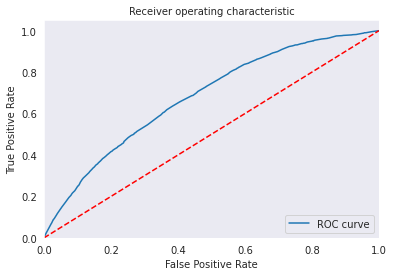

In [44]:
pred_prob_train = pd.Series(mod_cb.predict_proba(X_train)[:,1], name='pc')
pred_prob_valid = pd.Series(mod_cb.predict_proba(X_valid)[:, 1], name='pc')
pred_prob_test = pd.Series(mod_cb.predict_proba(X_test)[:, 1], name='pc')

train_scored = pd.concat([train, pred_prob_train], axis=1)
valid_scored = pd.concat([valid, pred_prob_valid], axis=1)
test_scored = pd.concat([test, pred_prob_test], axis=1)

somers_d_train = round(2*roc_auc_score(train_scored[response], train_scored.pc)-1, 4)
somers_d_valid = round(2*roc_auc_score(valid_scored[response], valid_scored.pc)-1, 4)
somers_d_test = round(2*roc_auc_score(test_scored[response], test_scored.pc)-1, 4)

print('Somers\'D TRAIN:\t\t', somers_d_train, '\nSomers\'D VALID:\t\t', somers_d_valid, '\nSomers\'D TEST:\t\t', somers_d_test)
display_roc_curve(train_scored[response], train_scored.pc);

### 7.6 Precision/recall evaluation on test set

Actual TEST precision:  2.47% 
Actual TEST recall:    40.45%
Actual TRAIN precision: 2.45% 
Actual TRAIN recall:   40.04%
Actual VALID precision: 2.42% 
Actual VALID recall:   39.68%
               precision    recall  f1-score   support

Non-Converted       0.99      0.81      0.89    336192
    Converted       0.02      0.40      0.05      3965

     accuracy                           0.81    340157
    macro avg       0.51      0.61      0.47    340157
 weighted avg       0.98      0.81      0.88    340157



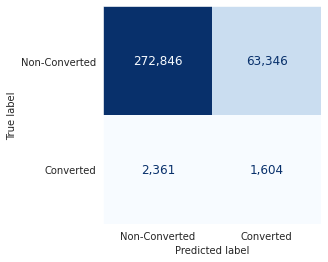

In [46]:
threshold = 0.017
labels = ['Non-Converted', 'Converted']
cm_train = classification_table(train_scored[response], train_scored.pc, threshold=threshold)
cm_valid = classification_table(valid_scored[response], valid_scored.pc, threshold=threshold)
cm_test = classification_table(test_scored[response], test_scored.pc, threshold=threshold)

print(f'Actual TEST precision:  {cm_test[1][1]/(cm_test[1][1]+cm_test[0][1]):,.2%} \nActual TEST recall:    {cm_test[1][1]/(cm_test[1][1]+cm_test[1][0]):,.2%}')
print(f'Actual TRAIN precision: {cm_train[1][1]/(cm_train[1][1]+cm_train[0][1]):,.2%} \nActual TRAIN recall:   {cm_train[1][1]/(cm_train[1][1]+cm_train[1][0]):,.2%}')
print(f'Actual VALID precision: {cm_valid[1][1]/(cm_valid[1][1]+cm_valid[0][1]):,.2%} \nActual VALID recall:   {cm_valid[1][1]/(cm_valid[1][1]+cm_valid[1][0]):,.2%}')

plot_confusion_matrix(cm_test, display_labels=labels);
classification_statistics(test_scored[response], test_scored.pc, threshold=threshold, target_names=['Non-Converted', 'Converted'])

## 8. Export to HTML

In [624]:
os.system('jupyter nbconvert campaigns_optimisation_binary_classifier.ipynb \
          --output ../output/campaigns_optimisation_binary_classifier \
          --to html \
          --no-prompt \
          --SlidesExporter.reveal_transition=fade');